# TSP problem using CE Method 

In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import permutations

In [127]:
class TSP(object):
    """Classe permettant de résoudre un problème TSP, deux versions sont disponibles :
        -la version originale proposée par les auteurs de la méthode (avec un smooth update possible)
        -une version prenant une approche bayésienne
    
    Attributs à entrer par l'utilisateur:
        c: matrice de poids pour les trajets entre les villes.
        methode: au choix entre "CE" pour la 1ere version et "Bayes" pour la 2nd
        k: nombre de simulations pour chaque update de la forme k*(nombre villes)^2 (int)
        perc: percentile fixé dans l'algo (int entre 1 et 100) 
        seed: graine pour fixer l'aléatoire (int)
        stop: critère d'arrêt (on s'arrète quand les d derniers quantiles sont les mêmes)
        alpha: "smoothing" parameter (1ere version only)
        
    Attributs:
        n: nombre de villes
        N: nombre de simulations pour chaque update
        p: matrice de transition entre les villes (pij proba de passer de la ville i à la ville j),
           initialisée par des Dirichlet uniformes
        p_old: version de p de l'update précédent (1ere version only)
        r: matrice des paramètres de Dirichlet (chaque ligne correspond à une Dirichlet), 
           initialisée avec alpha=1 (2eme version only)
        r_old: version de r de l'update précédent (2eme version only)
        
        
    Méthodes: (Voir aide spécifique à chaque méthode pour plus de détails)
    """
    
    def __init__(self, c, methode="CE", k=10, perc=1, alpha=0.9, seed=None, stop=5, show_p=5,show_q=10):
        """Constructeur de la classe TSPBayes"""
        
        if methode not in ["CE","Bayes"]:
            print("Mauvaise méthode, méthodes disponibles : Bayes, CE")
            sys.exit(1)
            
        self.c = c
        self.methode = methode
        self.n = c.shape[0]
        self.N = k * self.n**2
        self.perc = perc
        self.seed = seed
        self.stop = stop
        self.solution = None
        self.show_p = show_p
        self.show_q = show_q
        if self.methode=="CE":
            self.alpha = alpha
            self.p=(np.ones((self.n,self.n))-np.eye(self.n))*(1/float(self.n-1))
            self.p_old = self.p
            
        if self.methode=="Bayes":
            self.p = self.p_init()
            self.r = np.ones((self.n,self.n)) - np.eye(self.n)
            self.r_old = self.r

    def gen_dir(self,alpha):
        '''Simule 1 observation de loi de Dirichlet. (2eme version only)
        Ne prend en compte que les paramètres positifs'''
        
        alpha = alpha[alpha>0]
        
        return np.random.dirichlet(alpha,1)
        

    def p_init(self):
        """Initialise la matrice p avec des Dirichlet uniformes (2eme version only)
        Chaque ligne est simulée selon une Dirichlet(1,...,1) 
        """
        
        p = np.zeros((self.n,self.n))
        
        for i in range(self.n):
            
            row = self.gen_dir(np.tile(1,self.n-1))
            #On insert des 0 car la matrice p ne doit contenir que des 0 sur sa diagonale
            row = np.insert(row,i,0)
            p[i,:] = row

        return p
        
    def generate_tours(self):
        """Génère N tours selon les probabilités de transition de p
        Retourne une matrice de taille N*n où chaque ligne est un tour"""
    
        #première ville toujours 0 (mieux de prendre 0 que 1 pour les indices des matrices)
        #Fixer la ville de départ se fait sans perte de généralité
        tours = np.zeros((self.N,(self.n+1)),dtype=int)

        for obs in range(self.N):
            
            p = self.p.copy()
            
            for step in range(1,(self.n)):
                
                #colonne dernière ville du tour mise à 0 pour qu'on n'y repasse pas
                p[:,tours[obs,(step-1)]] = 0 
                
                with np.errstate(invalid='ignore', divide='ignore'): 
                    p = (np.divide(p.T,p.sum(axis=1))).T #renormalise pour que les colonnes somment à 1
                
                #génère une multinomiale(1,p1,...,pn) pour trouver la prochaine ville
                tours[obs,step] = np.random.choice(np.arange(self.n),1, p=p[tours[obs,(step-1)],:])[0]
                
            tours[obs,-1] = 0 #retour à la ville 0 (départ)
            
        return tours
        
    def S(self,x):
        '''Calcule la performance du tour par rapport à la matrice de poids c
        Performance = somme des distances parcourues entre les villes'''
        
        score = 0
        for i in range(len(x)-1):
            score += self.c[x[i],x[i+1]] #cout d'aller d'une ville à une autre 

        return score
    
    def construct_mult(self,x,score,q):
        '''Construction des observations multinomiales à partir des tours, 
        de leur score et du quantile (2eme version only)'''
        
        m =  np.zeros_like(self.r)
    
        x = x[score<=q,:]
        
        for obs in range(x.shape[0]):
            
            for idx in range(x.shape[1]-1):
                i = x[obs,idx]
                j = x[obs,idx+1]
                m[i,j] += 1
   
        return m

    
    def update_Bayes(self,x,score,q):
        '''Update bayésien de la matrice p. (2eme version only)
        Calcul des nouveau coefficients des Dirichlet par la formule de Bayes 
        simulation de la nouvelle matrice p par ces lois Dirichlet'''
        
        r_temp = self.r.copy()
        self.r = self.construct_mult(x,score,q)
        self.r_old = r_temp
        
        self.r = self.r + self.r_old
        
        p = np.zeros((self.n,self.n))
        
        for i in range(self.n):
            
            u = self.gen_dir(self.r[i,:])
            u = np.insert(u,i,0)
            p[i,:] = u
            
        self.p = p
            
        return None
    
    def update_CE(self,x, score,q):
        '''Permet de faire l'update "smooth" des probas de transition pij (1ere version only)
        la methode "smooth" evite les problemes avec des 0 au mauvais endroits'''
        self.p_old = self.p.copy()
        p =  np.zeros_like(self.p)
        
        x = x[score<=q,:]
        
        for obs in range(x.shape[0]):
            
            for idx in range(x.shape[1]-1):
                i = x[obs,idx]
                j = x[obs,idx+1]
                p[i,j] += 1

        p = np.divide(p,float(x.shape[0]))
        
        self.p = self.alpha*p + (1-self.alpha)*self.p_old
             
        return None
    
    
    def show_prob(self):
        '''Affiche p sous forme de HeatMap'''
        
        plt.figure(figsize=(8,8))
        plt.matshow(self.p,fignum=1)
        plt.xlabel('j')
        plt.ylabel('i')
        plt.grid('off')
        plt.colorbar()
        plt.show()
    
 
    def CE_fit(self):
        
        if self.seed: 
         #fixe aléa
         np.random.seed(self.seed)
         
        #Critére d'arrêt : les 'stop' derniers quantiles calculés sont les mêmes, q_memory les stockent
        #q_memory = np.zeros(self.stop)
        q_memory = np.array([])
        
        epoch = 0
        best_score = np.infty
        
        print("Vous utilisez la méthode : {}".format(self.methode))
        
        while True:
            epoch += 1
            print("Epoch {}".format(epoch))
            
            #genere les "tours"
            x = self.generate_tours().astype(np.int)
            
            #calcul du score pour chaque tour
            score = np.apply_along_axis(lambda x: self.S(x),1,x)
            
            #quantile
            q = np.percentile(score,self.perc)
            
            best = np.min(score)
            if best < best_score: 
                best_score = best
                self.solution = x[np.argmin(score),:]
                
            print("Quantile : {}, Meilleur score : {}".format(q,best))
            
            #on update nos quantiles pour le critère d'arrêt dans la memory
            #q_memory[:-1] = q_memory[1:]
            #q_memory[-1] = q
            q_memory = np.append(q_memory,[q])
                        
            if epoch%self.show_p==0: 
                self.show_prob()
                
            if epoch%self.show_q==0: 
                plt.plot(q_memory)
                plt.show()
            
            if self.methode=="CE":
                #smooth update
                self.update_CE(x,score,q)
                
            if self.methode=="Bayes":
                self.update_Bayes(x,score,q)
                
            #si les 5 derniers quantiles sont les mêmes ont arrête
            if len(q_memory)>5:
                if len(set(q_memory[-self.stop:]))==1 : break  
        
        #Affichage finale
        self.show_prob()
        plt.plot(q_memory)
        plt.show()
        print("final epoch {}, dernier quantile : {}".format(epoch,q))
        print("Meilleur score {}, solution : {}".format(best_score,self.solution))
                
        return

# Applications

In [128]:
def get_distance_from_cartesian(arr):
    '''Fonction permettant de calculer la matrice des distances à partir d'une liste de coordonnées cartésiennes'''
    
    n = arr.shape[0]
    c = np.zeros((n,n))
    
    for i in range(n):
        for j in range(i,n):
            c[i,j] = np.sqrt((arr[i,0]-arr[j,0])**2 + (arr[i,1]-arr[j,1])**2)
            
    c += c.T
    
    return c

In [129]:
from math import sin, cos, sqrt, atan2, radians

def get_distance_from_geographic(arr):
    '''Fonction permettant de calculer la matrice des distances à partir d'une liste
    de latitudes et longitudes'''
    
    # approximate radius of earth in km
    R = 6373.0
    n = arr.shape[0]
    distance_mat = np.zeros((n,n))
    
    for i in range(n):
        for j in range(i,n):
        
            lat1 = radians(arr[i,0])
            lon1 = radians(arr[i,1])
            lat2 = radians(arr[j,0])
            lon2 = radians(arr[j,1])
            
            dlon = lon2 - lon1
            dlat = lat2 - lat1

            a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
            c = 2 * atan2(sqrt(a), sqrt(1 - a))

            distance = R * c
            distance_mat[i,j] = distance
            
    distance_mat += distance_mat.T
    
    return distance_mat

In [130]:
def best_score(TSP):
    '''Calcul la vraie solution d'un probleme TSP
    La taille de la boucle est n! donc à ne pas tester sur plus d'une dizaine de villes'''
    
    mini = np.infty
    for tours in permutations(range(1,TSP.n)):
        s = TSP.S((0,) + tours + (0,))
        if s< mini:
            mini = s
    return mini

In [131]:
def CE_solution(c,method="CE",k=10,perc=1,alpha=0.9):
    '''Fit la classe TSP sur un matrice de distances c'''
    
    tsp = TSP(c,k=k,perc=perc,methode=method,alpha=alpha)
    tsp.CE_fit()
    return tsp

In [132]:
def plot_solution_cartesian(tsp,d):
    '''tsp : objet TSP fitté, 
    d :  matrice contenant les coordonnées cartésiennes'''

    #Ensemble de points
    print("Ensemble des villes dans le plan")
    plt.plot(d[:,0],d[:,1],".")
    plt.axis("off")
    plt.show()
    
    #Solution
    print("Trajet optimal")
    permut = tsp.solution
    plt.plot(my_data[permut,0],my_data[permut,1])
    plt.axis("off")
    plt.show()

## Examples à moins de 20 villes

In [57]:
my_data = np.genfromtxt('tiny.csv', delimiter=',')
my_data

array([[-1.0856306 , -0.67888615],
       [ 0.99734545, -0.09470897],
       [ 0.2829785 ,  1.49138963],
       [-1.50629471, -0.638902  ],
       [-0.57860025, -0.44398196],
       [ 1.65143654, -0.43435128],
       [-2.42667924,  2.20593008],
       [-0.42891263,  2.18678609],
       [ 1.26593626,  1.0040539 ],
       [-0.8667404 ,  0.3861864 ]])

In [58]:
c = get_distance_from_cartesian(my_data)
c

array([[0.        , 2.16334283, 2.56577236, 0.42256009, 0.55880207,
        2.74796904, 3.1812853 , 2.93995848, 2.89173891, 1.08733273],
       [2.16334283, 0.        , 1.73954847, 2.56210072, 1.61418601,
        0.73701564, 4.12515274, 2.69061922, 1.13111488, 1.92511724],
       [2.56577236, 1.73954847, 0.        , 2.78202103, 2.11848557,
        2.36244691, 2.80228713, 0.99517095, 1.09713357, 1.5947814 ],
       [0.42256009, 2.56210072, 2.78202103, 0.        , 0.94795086,
        3.16434948, 2.99001292, 3.02411397, 3.22250968, 1.20823671],
       [0.55880207, 1.61418601, 2.11848557, 0.94795086, 0.        ,
        2.23005758, 3.23070113, 2.63502313, 2.34502085, 0.87875153],
       [2.74796904, 0.73701564, 2.36244691, 3.16434948, 2.23005758,
        0.        , 4.85820069, 3.34637322, 1.48916752, 2.6484896 ],
       [3.1812853 , 4.12515274, 2.80228713, 2.99001292, 3.23070113,
        4.85820069, 0.        , 1.99785834, 3.8832867 , 2.39684715],
       [2.93995848, 2.69061922, 0.9951709

Vous utilisez la méthode : Bayes
Epoch 1
Quantile : 17.4371328939, Meilleur score : 15.9746642839
Epoch 2
Quantile : 15.0555992943, Meilleur score : 13.4569095786
Epoch 3
Quantile : 14.0292636163, Meilleur score : 13.3796036929
Epoch 4
Quantile : 13.4569095786, Meilleur score : 12.7747969708
Epoch 5
Quantile : 13.3796036929, Meilleur score : 12.7747969708


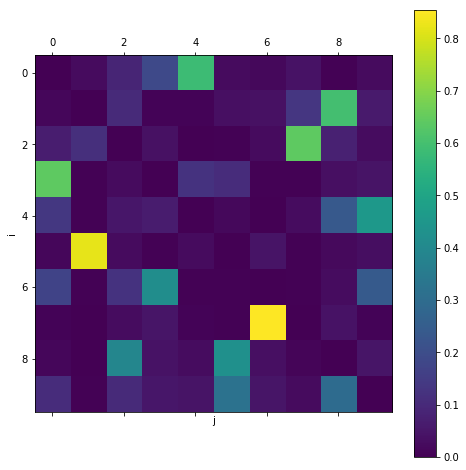

Epoch 6
Quantile : 13.3523720369, Meilleur score : 12.7747969708
Epoch 7
Quantile : 13.0430417804, Meilleur score : 12.7747969708
Epoch 8
Quantile : 12.7747969708, Meilleur score : 12.7747969708
Epoch 9
Quantile : 12.7747969708, Meilleur score : 12.7747969708
Epoch 10
Quantile : 12.7747969708, Meilleur score : 12.7747969708


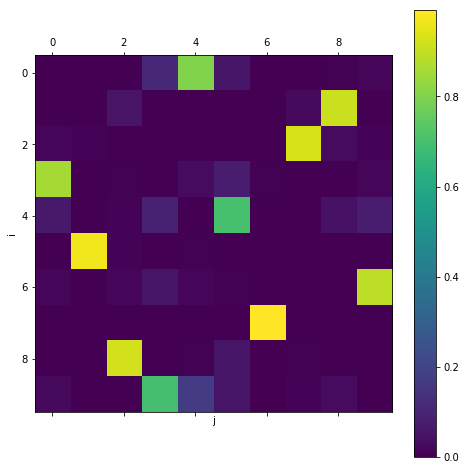

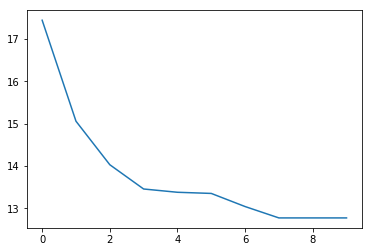

Epoch 11
Quantile : 12.7747969708, Meilleur score : 12.7747969708
Epoch 12
Quantile : 12.7747969708, Meilleur score : 12.7747969708


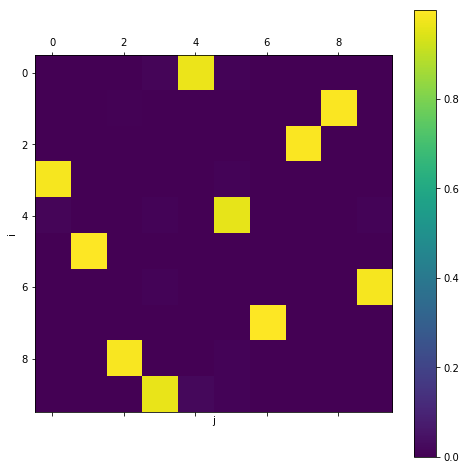

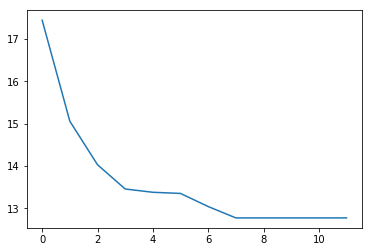

final epoch 12, dernier quantile : 12.7747969708
Meilleur score 12.7747969708, solution : [0 4 5 1 8 2 7 6 9 3 0]
CPU times: user 8.18 s, sys: 226 ms, total: 8.4 s
Wall time: 7.62 s


In [59]:
%%time
tsp = CE_solution(c,method="Bayes")

In [60]:
print(tsp.solution)

[0 4 5 1 8 2 7 6 9 3 0]


Visualisation de la solution

Ensemble des villes dans le plan


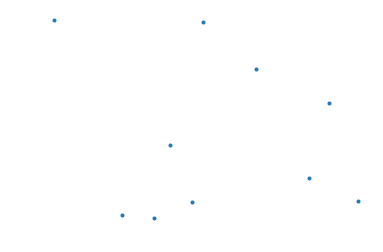

Trajet optimal


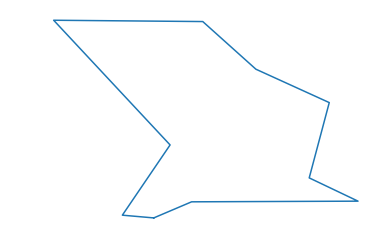

In [70]:
plot_solution_cartesian(tsp,my_data)

## Examples à moins de 30 villes

In [135]:
my_data = np.genfromtxt('small.csv', delimiter=',')

In [136]:
c = get_distance(my_data)
c.shape

NameError: name 'get_distance' is not defined

Vous utilisez la méthode : CE
Epoch 1
Quantile : 224.722006221, Meilleur score : 166.200409262
Epoch 2
Quantile : 157.740605259, Meilleur score : 106.423013882
Epoch 3
Quantile : 114.770701974, Meilleur score : 90.8729174123
Epoch 4
Quantile : 93.8894590928, Meilleur score : 79.7158769614
Epoch 5
Quantile : 84.1933624174, Meilleur score : 71.9405699546


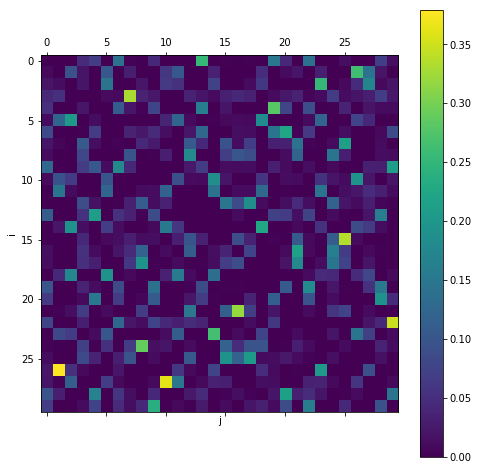

Epoch 6
Quantile : 78.251906305, Meilleur score : 70.9173048917
Epoch 7
Quantile : 74.8883919311, Meilleur score : 66.3631051453
Epoch 8
Quantile : 72.4084292499, Meilleur score : 65.899264206
Epoch 9
Quantile : 70.4491614929, Meilleur score : 65.7081540394
Epoch 10
Quantile : 68.348440634, Meilleur score : 64.467345934


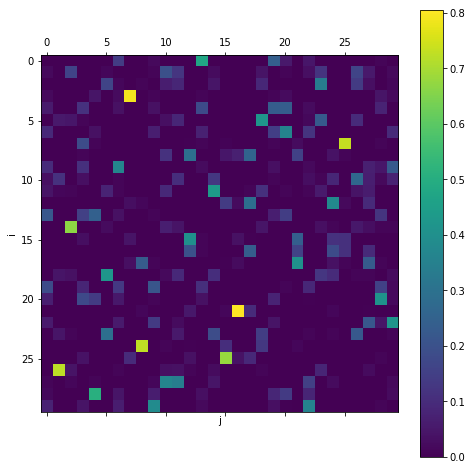

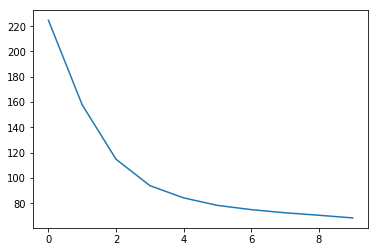

Epoch 11
Quantile : 66.8126865298, Meilleur score : 63.6714268128
Epoch 12
Quantile : 65.2061217848, Meilleur score : 62.5604245797
Epoch 13
Quantile : 63.5483578756, Meilleur score : 61.6442338057
Epoch 14
Quantile : 62.1714915952, Meilleur score : 60.8422718021
Epoch 15
Quantile : 60.8422718021, Meilleur score : 60.4051551351


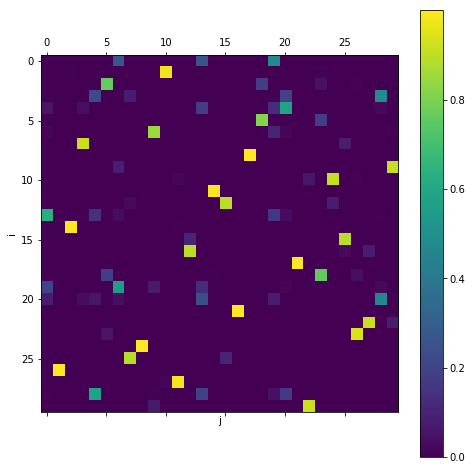

Epoch 16
Quantile : 60.4051551351, Meilleur score : 60.1773663655
Epoch 17
Quantile : 60.4051551351, Meilleur score : 60.4051551351
Epoch 18
Quantile : 60.4051551351, Meilleur score : 60.4051551351
Epoch 19
Quantile : 60.4051551351, Meilleur score : 60.4051551351
Epoch 20
Quantile : 60.4051551351, Meilleur score : 60.4051551351


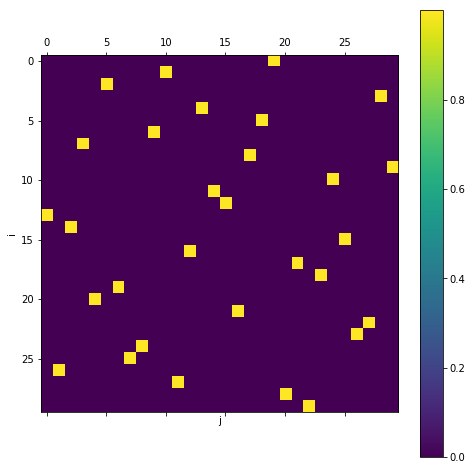

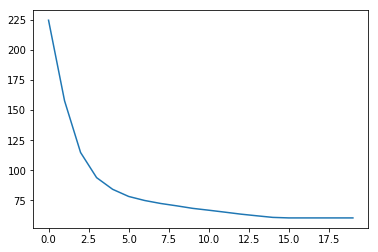

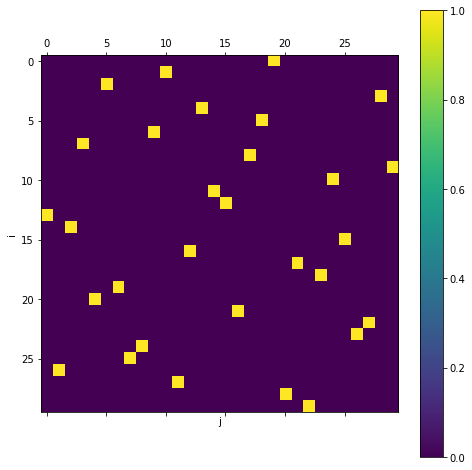

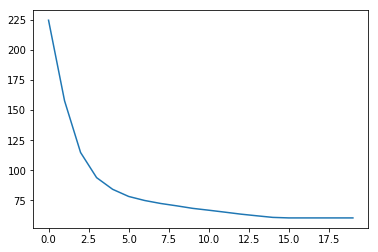

final epoch 20, dernier quantile : 60.4051551351
Meilleur score 60.1773663655, solution : [ 0 19  6  9 29 22 27 11 14  2 18  5 23 26  1 10 24  8 17 21 16 12 15 25
  7  3 28 20  4 13  0]
CPU times: user 5min 14s, sys: 2.42 s, total: 5min 17s
Wall time: 5min 23s


In [55]:
%%time
tsp = CE_solution(c,method="CE")

In [56]:
print(tsp.solution)

[ 0 19  6  9 29 22 27 11 14  2 18  5 23 26  1 10 24  8 17 21 16 12 15 25
  7  3 28 20  4 13  0]


Ensemble des villes dans le plan


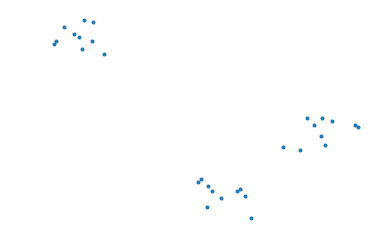

Trajet optimal


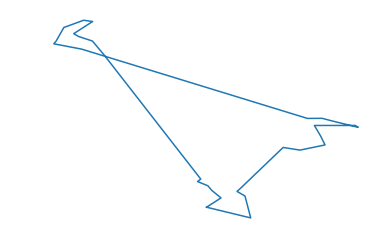

In [57]:
plot_solution(tsp,my_data)

## Tour du monde

In [2]:
df = pd.read_csv("../worldcities.csv")

In [3]:
print(df.shape)
df.head()

(12959, 11)


,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
0,Malishevë,Malisheve,42.4822,20.7458,Kosovo,XK,XKS,Malishevë,admin,NaN,1901597212
1,Prizren,Prizren,42.2139,20.7397,Kosovo,XK,XKS,Prizren,admin,NaN,1901360309
2,Zubin Potok,Zubin Potok,42.9144,20.6897,Kosovo,XK,XKS,Zubin Potok,admin,NaN,1901608808
3,Kamenicë,Kamenice,42.5781,21.5803,Kosovo,XK,XKS,Kamenicë,admin,NaN,1901851592
4,Viti,Viti,42.3214,21.3583,Kosovo,XK,XKS,Viti,admin,NaN,1901328795


In [4]:
df = df[df.capital=="primary"]
df = df[~(df.population.isna())]
print(df.shape)

(217, 11)


In [5]:
df.head()

,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
39,Sanaa,Sanaa,15.3547,44.2066,Yemen,YE,YEM,Amānat al ‘Āşimah,primary,2008000.0,1887750814
135,Pretoria,Pretoria,-25.7069,28.2294,South Africa,ZA,ZAF,Gauteng,primary,1338000.0,1710176249
136,Bloemfontein,Bloemfontein,-29.1200,26.2299,South Africa,ZA,ZAF,Free State,primary,463064.0,1710495933
137,Cape Town,Cape Town,-33.9200,18.4350,South Africa,ZA,ZAF,Western Cape,primary,3215000.0,1710680650
140,Lusaka,Lusaka,-15.4166,28.2833,Zambia,ZM,ZMB,Lusaka,primary,1328000.0,1894157390


In [6]:
#On ne sélectionne que les p plus grandes villes en terme de population
p = 25
df = df.sort_values("population")[-p:]
print(df.shape)
df.to_csv("worldtour.csv",index=None)

(25, 11)


In [142]:
#On construit la matrice des distances
my_data = df[["lat","lng"]].values
c = get_distance_from_geographic(my_data)
c.shape

(25, 25)

### Smooth Update

Vous utilisez la méthode : CE
Epoch 1
Quantile : 174686.011515, Meilleur score : 151551.960037
Epoch 2
Quantile : 136117.414296, Meilleur score : 119701.134345
Epoch 3
Quantile : 111881.204628, Meilleur score : 88073.0102416
Epoch 4
Quantile : 95567.4393759, Meilleur score : 82084.7710172
Epoch 5
Quantile : 84979.6983047, Meilleur score : 75932.9450042


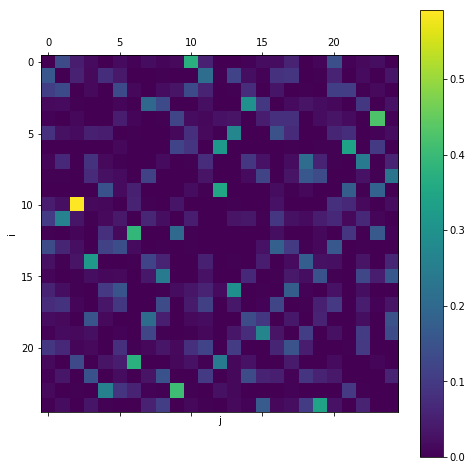

Epoch 6
Quantile : 78477.9755086, Meilleur score : 70926.0770057
Epoch 7
Quantile : 73248.0076438, Meilleur score : 66106.7170661
Epoch 8
Quantile : 68976.2466222, Meilleur score : 64459.3998352
Epoch 9
Quantile : 66577.8876163, Meilleur score : 62039.1174817
Epoch 10
Quantile : 64210.3561722, Meilleur score : 61290.3759039


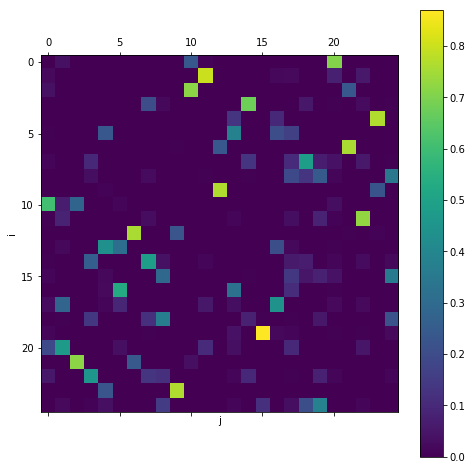

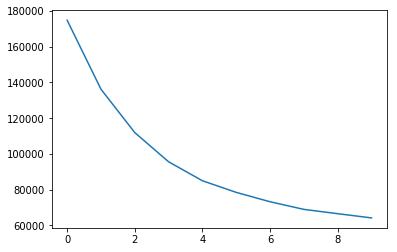

Epoch 11
Quantile : 61933.3628238, Meilleur score : 59829.0499996
Epoch 12
Quantile : 61487.1445627, Meilleur score : 59010.4400167
Epoch 13
Quantile : 60324.3506887, Meilleur score : 59829.0499996
Epoch 14
Quantile : 59829.0499996, Meilleur score : 58515.1393276
Epoch 15
Quantile : 59829.0499996, Meilleur score : 58515.1393276


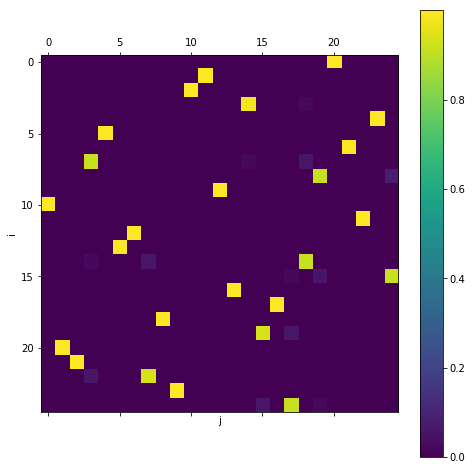

Epoch 16
Quantile : 59829.0499996, Meilleur score : 58515.1393276
Epoch 17
Quantile : 59829.0499996, Meilleur score : 59829.0499996
Epoch 18
Quantile : 59829.0499996, Meilleur score : 59829.0499996


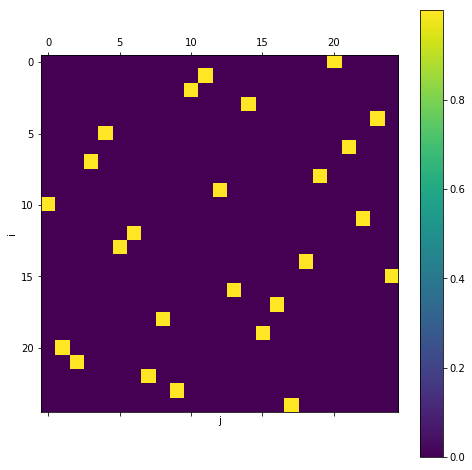

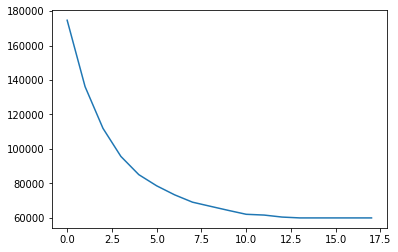

final epoch 18, dernier quantile : 59829.0499996
Meilleur score 58515.1393276, solution : [ 0 20  1 11 22  7  3 14 18  8 24 15 19 17 16 13  5  4 23  9 12  6 21  2
 10  0]
CPU times: user 2min 38s, sys: 1.05 s, total: 2min 39s
Wall time: 2min 39s


In [108]:
%%time
tsp_Smooth = CE_solution(c,method="CE",alpha=0.8)

In [110]:
print(tsp_Smooth.solution)

[ 0 20  1 11 22  7  3 14 18  8 24 15 19 17 16 13  5  4 23  9 12  6 21  2
 10  0]


### Bayesian

Vous utilisez la méthode : Bayes
Epoch 1
Quantile : 167810.541913, Meilleur score : 137448.196752
Epoch 2
Quantile : 135865.642153, Meilleur score : 107487.593977
Epoch 3
Quantile : 124629.087181, Meilleur score : 102327.233351
Epoch 4
Quantile : 115425.494651, Meilleur score : 95151.2985713
Epoch 5
Quantile : 110352.286939, Meilleur score : 89824.9183391


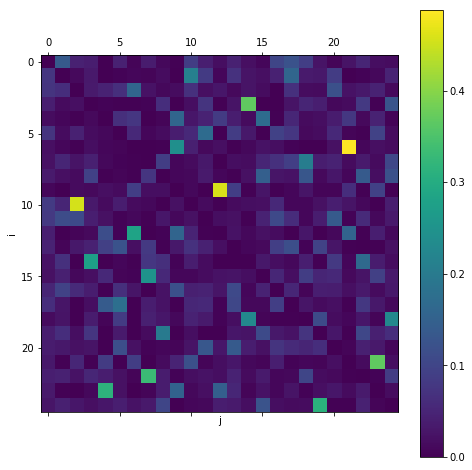

Epoch 6
Quantile : 106671.626347, Meilleur score : 84009.5846326
Epoch 7
Quantile : 103163.701912, Meilleur score : 87937.1855245
Epoch 8
Quantile : 100040.873894, Meilleur score : 80491.8984455
Epoch 9
Quantile : 99237.994317, Meilleur score : 81756.2707252
Epoch 10
Quantile : 97796.2881882, Meilleur score : 81908.7242613


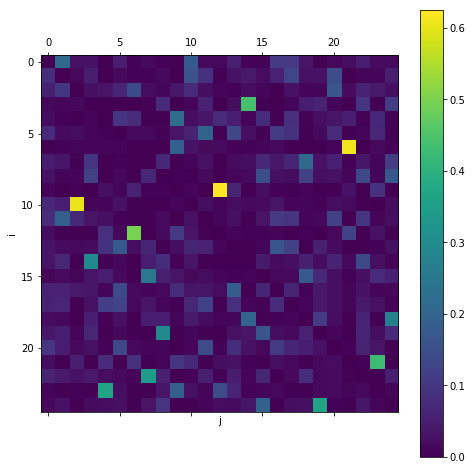

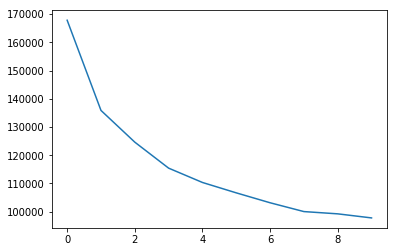

Epoch 11
Quantile : 95072.9269502, Meilleur score : 84660.9414057
Epoch 12
Quantile : 94465.123208, Meilleur score : 79213.2548853
Epoch 13
Quantile : 92737.9655924, Meilleur score : 79609.7072742
Epoch 14
Quantile : 93184.6950568, Meilleur score : 78057.8088087
Epoch 15
Quantile : 93272.0414869, Meilleur score : 78466.6393694


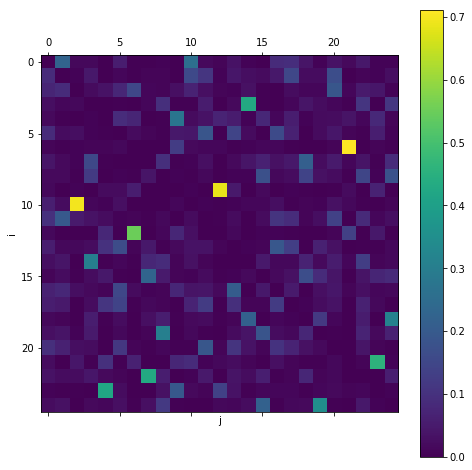

Epoch 16
Quantile : 90302.811928, Meilleur score : 77114.8630402
Epoch 17
Quantile : 89966.0067887, Meilleur score : 71762.4842571
Epoch 18
Quantile : 88996.0097802, Meilleur score : 76894.6685785
Epoch 19
Quantile : 87354.3416981, Meilleur score : 77795.3847187
Epoch 20
Quantile : 88755.8951205, Meilleur score : 73494.0224474


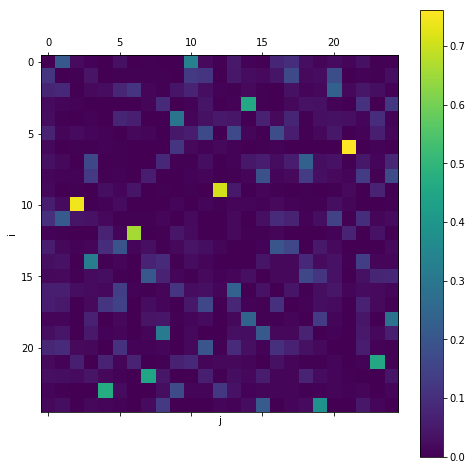

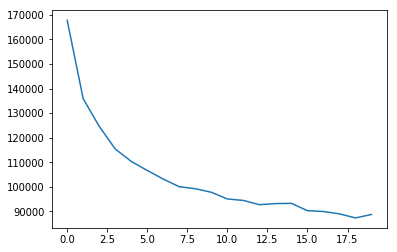

Epoch 21
Quantile : 87374.4719486, Meilleur score : 74383.5299851
Epoch 22
Quantile : 86633.3428935, Meilleur score : 76635.2930275
Epoch 23
Quantile : 86338.474805, Meilleur score : 74913.8783818
Epoch 24
Quantile : 86742.1932479, Meilleur score : 73375.6178264
Epoch 25
Quantile : 86418.7988203, Meilleur score : 76321.5181829


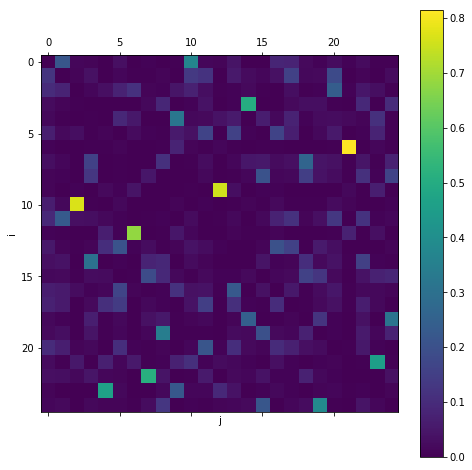

Epoch 26
Quantile : 85565.723071, Meilleur score : 76018.7505262
Epoch 27
Quantile : 84943.0526054, Meilleur score : 73812.517575
Epoch 28
Quantile : 84612.5301432, Meilleur score : 72659.0866446
Epoch 29
Quantile : 84390.5457082, Meilleur score : 75168.3124421
Epoch 30
Quantile : 83750.6676268, Meilleur score : 72194.0053847


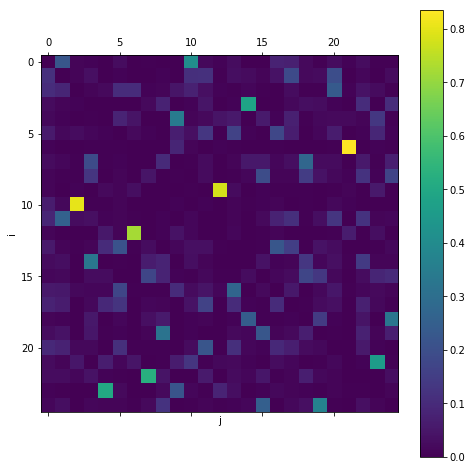

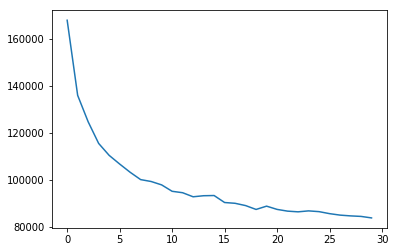

Epoch 31
Quantile : 84435.3683269, Meilleur score : 74672.0718917
Epoch 32
Quantile : 84573.1791665, Meilleur score : 77160.3423106
Epoch 33
Quantile : 83742.8993174, Meilleur score : 72171.1964326
Epoch 34
Quantile : 82124.5852091, Meilleur score : 71936.3284106
Epoch 35
Quantile : 82471.9297075, Meilleur score : 71149.0142891


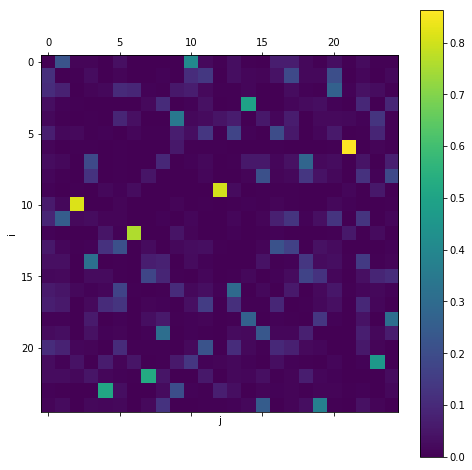

Epoch 36
Quantile : 82632.4076754, Meilleur score : 72427.3967977
Epoch 37
Quantile : 82365.9617316, Meilleur score : 75434.3216997
Epoch 38
Quantile : 82486.787637, Meilleur score : 73505.2897771
Epoch 39
Quantile : 82593.0211482, Meilleur score : 73682.4545263
Epoch 40
Quantile : 82122.2494348, Meilleur score : 73220.1640428


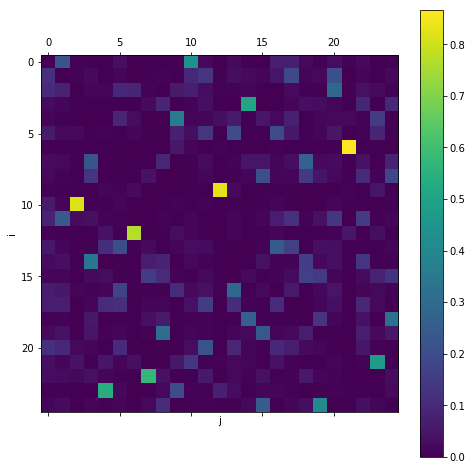

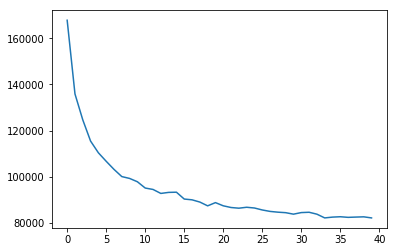

Epoch 41
Quantile : 81926.0048435, Meilleur score : 72569.5433765
Epoch 42
Quantile : 80913.7252048, Meilleur score : 71878.8543724
Epoch 43
Quantile : 81467.615523, Meilleur score : 72944.3642595
Epoch 44
Quantile : 80905.5506415, Meilleur score : 72624.5164916
Epoch 45
Quantile : 81397.7838634, Meilleur score : 75195.9240907


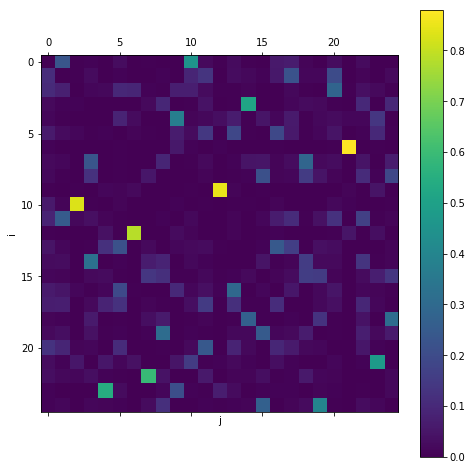

Epoch 46
Quantile : 81381.1882937, Meilleur score : 71416.9168151
Epoch 47
Quantile : 80829.0578525, Meilleur score : 72353.4710685
Epoch 48
Quantile : 80114.1428138, Meilleur score : 72185.4167895
Epoch 49
Quantile : 80948.0182348, Meilleur score : 72935.3585168
Epoch 50
Quantile : 80033.2172497, Meilleur score : 71041.9931676


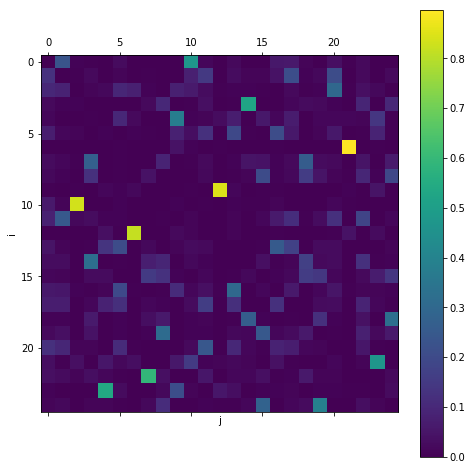

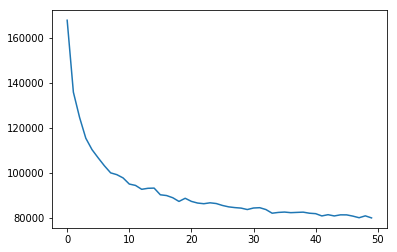

Epoch 51
Quantile : 80565.5953366, Meilleur score : 71352.8052042
Epoch 52
Quantile : 79768.4702623, Meilleur score : 71240.160483
Epoch 53
Quantile : 79851.5354979, Meilleur score : 67878.6658029
Epoch 54
Quantile : 79717.9008421, Meilleur score : 71183.9565492
Epoch 55
Quantile : 80421.0734091, Meilleur score : 72410.6294922


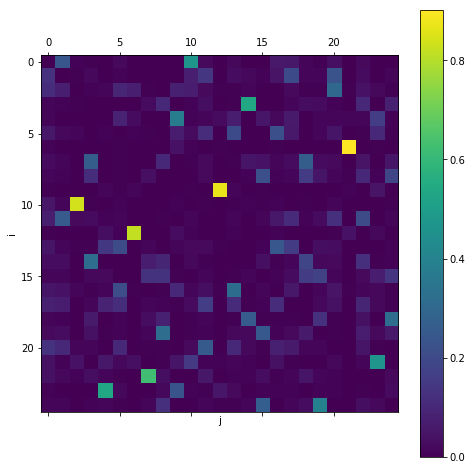

Epoch 56
Quantile : 79302.2572603, Meilleur score : 67369.7546999
Epoch 57
Quantile : 79864.7794307, Meilleur score : 65980.5769062
Epoch 58
Quantile : 79440.9645412, Meilleur score : 71424.4676843
Epoch 59
Quantile : 79566.7699504, Meilleur score : 71076.8823712
Epoch 60
Quantile : 79417.3855432, Meilleur score : 71734.4216837


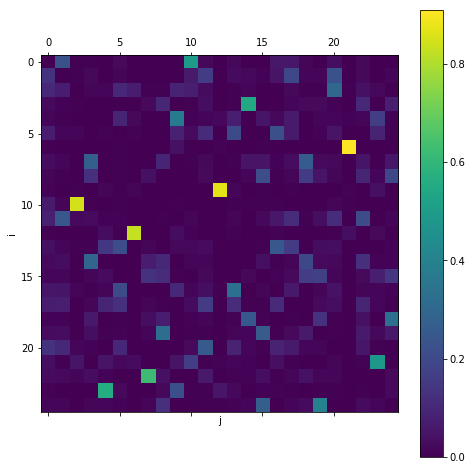

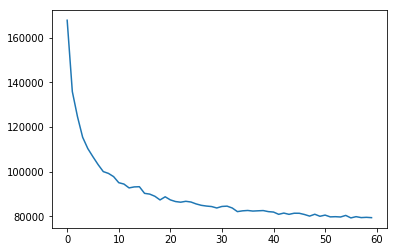

Epoch 61
Quantile : 78936.8310413, Meilleur score : 72779.964326
Epoch 62
Quantile : 78914.6733866, Meilleur score : 72313.5215777
Epoch 63
Quantile : 79312.5319365, Meilleur score : 70650.3185268
Epoch 64
Quantile : 78974.7997915, Meilleur score : 72985.4050831
Epoch 65
Quantile : 78426.6538283, Meilleur score : 70098.1081557


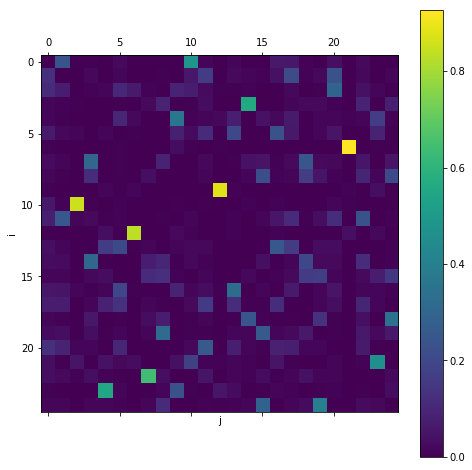

Epoch 66
Quantile : 78265.8160746, Meilleur score : 69427.7189098
Epoch 67
Quantile : 78713.4369602, Meilleur score : 69964.077213
Epoch 68
Quantile : 78596.0012723, Meilleur score : 69117.9850891
Epoch 69
Quantile : 78632.8136676, Meilleur score : 71449.2268023
Epoch 70
Quantile : 78481.8015695, Meilleur score : 68755.5347308


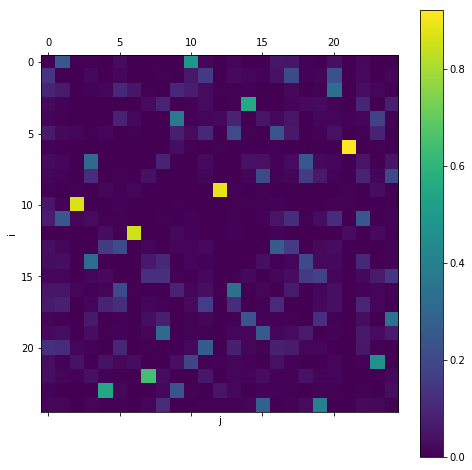

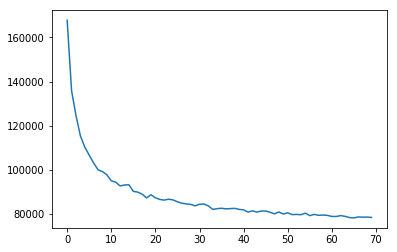

Epoch 71
Quantile : 78024.9418907, Meilleur score : 71604.6729175
Epoch 72
Quantile : 77290.9810828, Meilleur score : 69732.4092705
Epoch 73
Quantile : 77352.3168977, Meilleur score : 69106.4625931
Epoch 74
Quantile : 78251.7539111, Meilleur score : 71958.7953053
Epoch 75
Quantile : 77629.2139423, Meilleur score : 68967.1508766


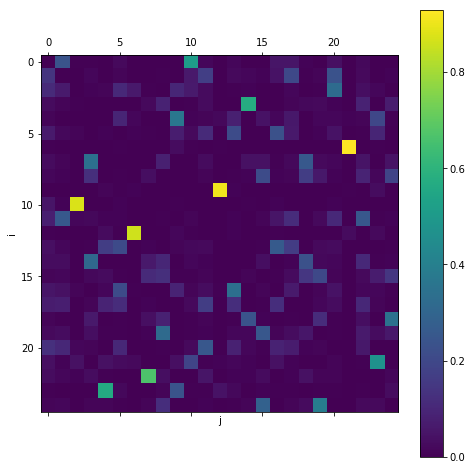

Epoch 76
Quantile : 77290.163914, Meilleur score : 69720.9532261
Epoch 77
Quantile : 77910.6315974, Meilleur score : 68348.6471201
Epoch 78
Quantile : 77549.7578333, Meilleur score : 67815.101354
Epoch 79
Quantile : 77028.2472934, Meilleur score : 66700.4957611
Epoch 80
Quantile : 77200.3655014, Meilleur score : 69530.8458949


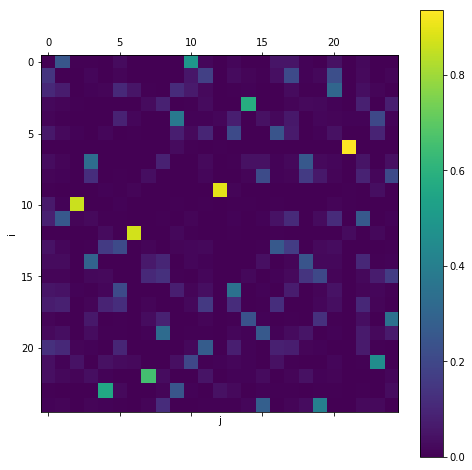

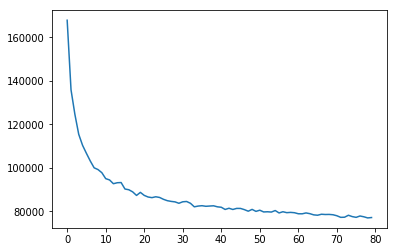

Epoch 81
Quantile : 77635.4076201, Meilleur score : 69680.4068722
Epoch 82
Quantile : 77599.6867128, Meilleur score : 67187.6468069
Epoch 83
Quantile : 76689.0218782, Meilleur score : 66092.9631731
Epoch 84
Quantile : 76529.4334731, Meilleur score : 65331.2729131
Epoch 85
Quantile : 76877.8488505, Meilleur score : 67893.0935617


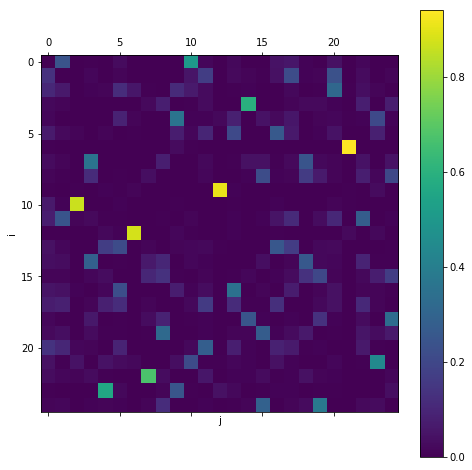

Epoch 86
Quantile : 76778.7595269, Meilleur score : 69665.2786181
Epoch 87
Quantile : 77015.2631368, Meilleur score : 69141.4678112
Epoch 88
Quantile : 76989.9564229, Meilleur score : 69177.2186991
Epoch 89
Quantile : 76437.4687389, Meilleur score : 68276.9093981
Epoch 90
Quantile : 76945.856627, Meilleur score : 69890.6333285


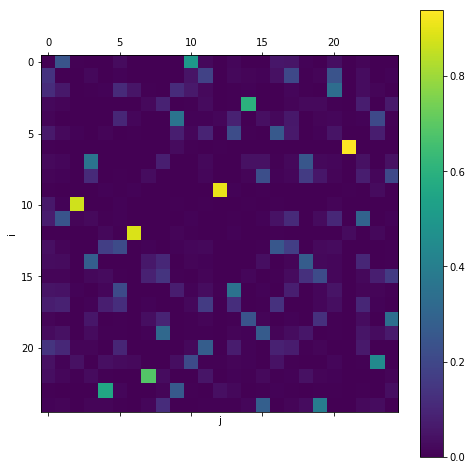

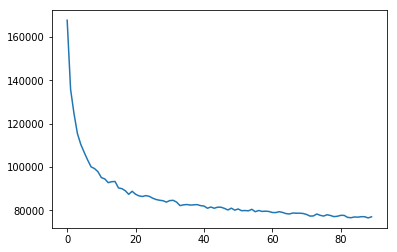

Epoch 91
Quantile : 76716.5840914, Meilleur score : 69176.1682362
Epoch 92
Quantile : 76991.170853, Meilleur score : 66880.0529771
Epoch 93
Quantile : 75681.2128885, Meilleur score : 69964.077213
Epoch 94
Quantile : 75978.8588342, Meilleur score : 69417.150708
Epoch 95
Quantile : 75703.3714466, Meilleur score : 68001.1720722


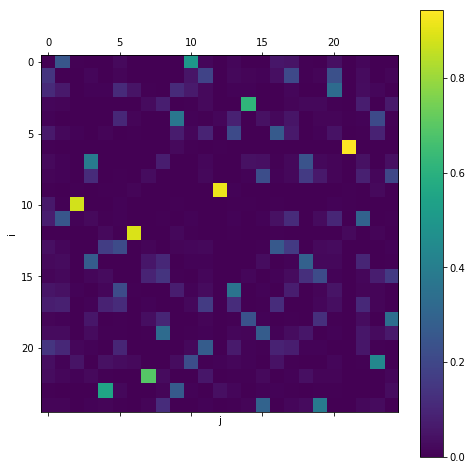

Epoch 96
Quantile : 76300.6913134, Meilleur score : 66857.5527783
Epoch 97
Quantile : 75974.4385157, Meilleur score : 67392.0392797
Epoch 98
Quantile : 75723.4412635, Meilleur score : 69289.1203584
Epoch 99
Quantile : 76230.8241558, Meilleur score : 69340.01219
Epoch 100
Quantile : 75713.5454318, Meilleur score : 68150.0868165


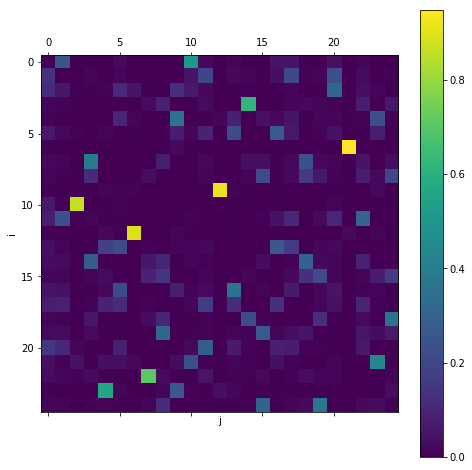

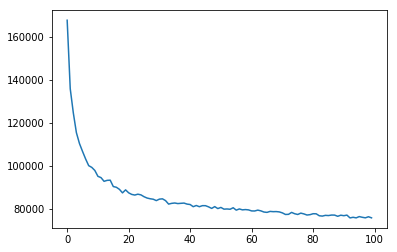

Epoch 101
Quantile : 76391.887633, Meilleur score : 69728.5495175
Epoch 102
Quantile : 75494.6841577, Meilleur score : 70017.2359003
Epoch 103
Quantile : 75097.8410861, Meilleur score : 68777.5680369
Epoch 104
Quantile : 75520.0988567, Meilleur score : 67499.2681769
Epoch 105
Quantile : 75807.5205666, Meilleur score : 67542.6589515


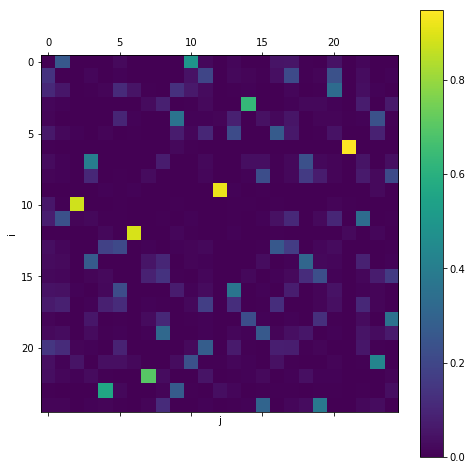

Epoch 106
Quantile : 75814.2567814, Meilleur score : 69823.0710964
Epoch 107
Quantile : 75338.4829053, Meilleur score : 67955.6191792
Epoch 108
Quantile : 75097.3109833, Meilleur score : 68116.5195456
Epoch 109
Quantile : 75341.1018062, Meilleur score : 65630.7457848
Epoch 110
Quantile : 75453.0213218, Meilleur score : 68662.6181203


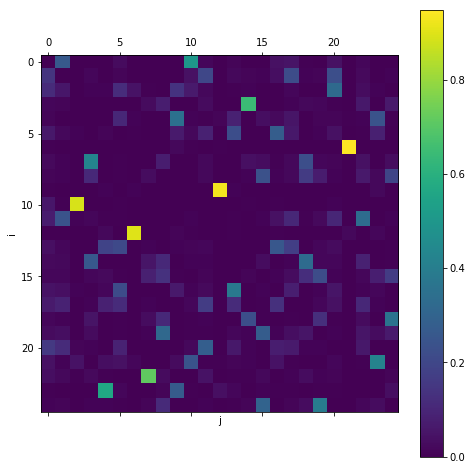

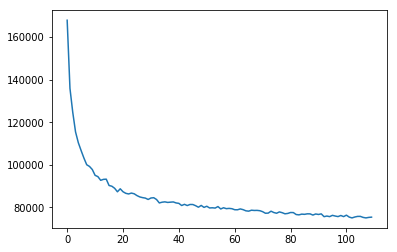

Epoch 111
Quantile : 75409.8379444, Meilleur score : 68242.5108596
Epoch 112
Quantile : 74822.6380979, Meilleur score : 67141.5531397
Epoch 113
Quantile : 75627.5882218, Meilleur score : 67297.1820526
Epoch 114
Quantile : 75132.5919243, Meilleur score : 66790.9218763
Epoch 115
Quantile : 75286.9131398, Meilleur score : 65298.8546961


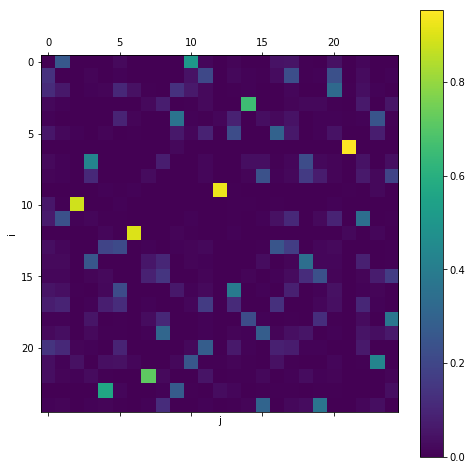

Epoch 116
Quantile : 74805.4772072, Meilleur score : 68556.4585396
Epoch 117
Quantile : 75402.1999957, Meilleur score : 65974.8751578
Epoch 118
Quantile : 74957.6760113, Meilleur score : 65446.4128681
Epoch 119
Quantile : 74892.3547373, Meilleur score : 68815.9937851
Epoch 120
Quantile : 74372.915142, Meilleur score : 67353.1683688


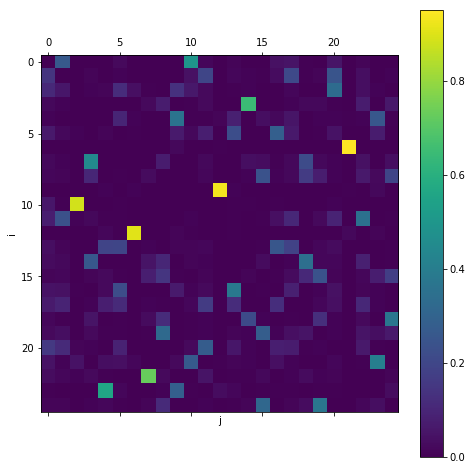

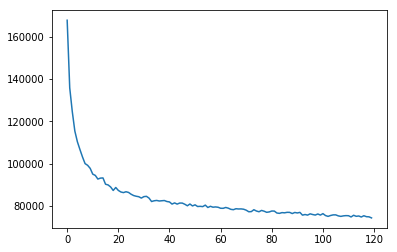

Epoch 121
Quantile : 74872.2816104, Meilleur score : 66717.3011407
Epoch 122
Quantile : 74673.3081904, Meilleur score : 68286.1607038
Epoch 123
Quantile : 74616.4955345, Meilleur score : 66057.6443522
Epoch 124
Quantile : 74010.4034033, Meilleur score : 66103.8752281
Epoch 125
Quantile : 74131.8318935, Meilleur score : 65078.7727776


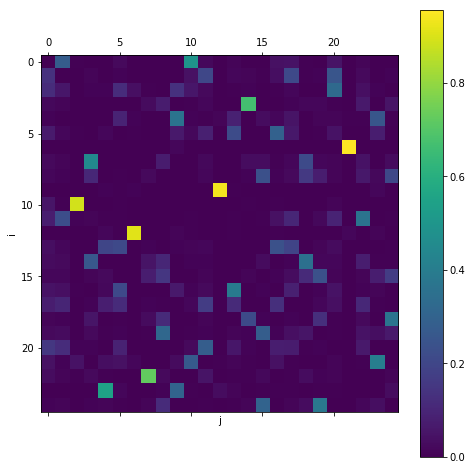

Epoch 126
Quantile : 74378.6953859, Meilleur score : 67132.7525881
Epoch 127
Quantile : 74647.6634775, Meilleur score : 68986.931255
Epoch 128
Quantile : 74128.4132574, Meilleur score : 67178.363388
Epoch 129
Quantile : 74715.8047084, Meilleur score : 65801.9745216
Epoch 130
Quantile : 74449.1313324, Meilleur score : 67954.8038202


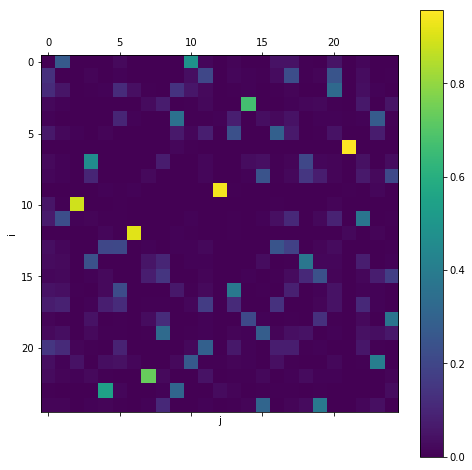

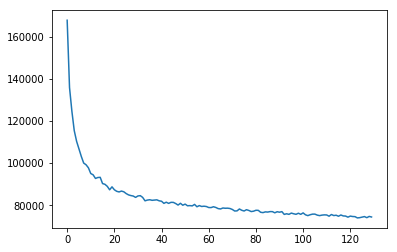

Epoch 131
Quantile : 74132.2604473, Meilleur score : 65083.7689473
Epoch 132
Quantile : 74148.8024989, Meilleur score : 64077.2781785
Epoch 133
Quantile : 73815.6468566, Meilleur score : 65537.1909096
Epoch 134
Quantile : 74178.1499679, Meilleur score : 65732.7805294
Epoch 135
Quantile : 73998.8414725, Meilleur score : 67234.9860393


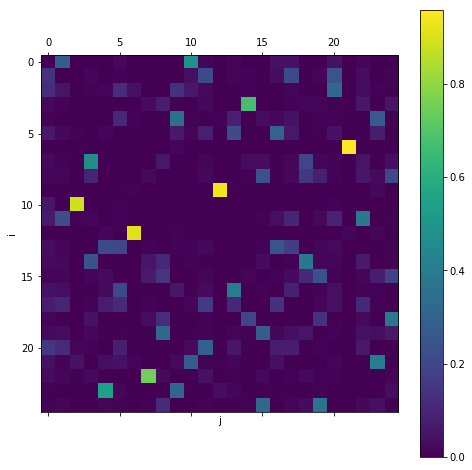

Epoch 136
Quantile : 73599.3958312, Meilleur score : 64867.1785462
Epoch 137
Quantile : 73925.9011123, Meilleur score : 65313.0325413
Epoch 138
Quantile : 73825.077912, Meilleur score : 67359.7011372
Epoch 139
Quantile : 73657.8546246, Meilleur score : 67624.376159
Epoch 140
Quantile : 73535.4265405, Meilleur score : 65227.1837115


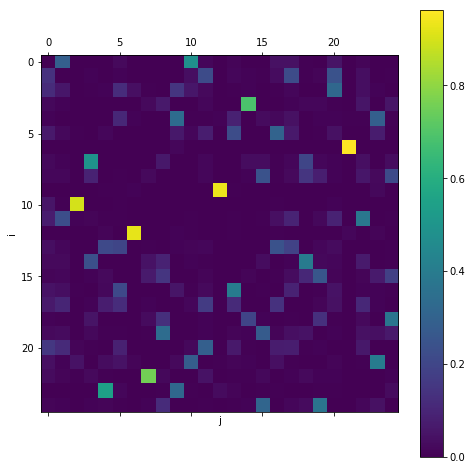

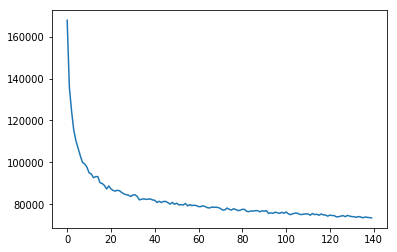

Epoch 141
Quantile : 73389.9179725, Meilleur score : 67082.9284547
Epoch 142
Quantile : 73212.440481, Meilleur score : 66527.6007244
Epoch 143
Quantile : 73766.7620364, Meilleur score : 66918.6279958
Epoch 144
Quantile : 73276.4112019, Meilleur score : 68119.772515
Epoch 145
Quantile : 73877.5407925, Meilleur score : 64219.8978127


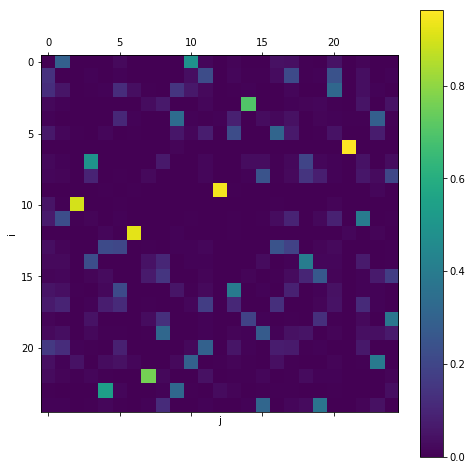

Epoch 146
Quantile : 73592.0316246, Meilleur score : 62053.3241591
Epoch 147
Quantile : 73729.2805803, Meilleur score : 64095.2148707
Epoch 148
Quantile : 72890.3434666, Meilleur score : 62579.0201721
Epoch 149
Quantile : 73041.3637664, Meilleur score : 65010.970819
Epoch 150
Quantile : 73518.9303194, Meilleur score : 61046.8333903


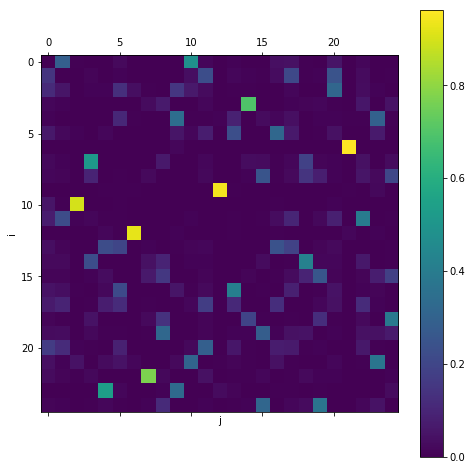

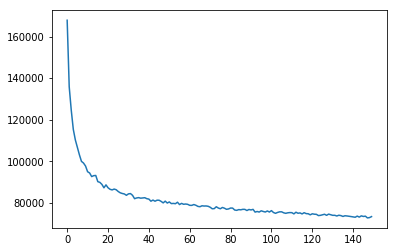

Epoch 151
Quantile : 73739.3299039, Meilleur score : 64848.1540718
Epoch 152
Quantile : 73314.4439714, Meilleur score : 62369.6822026
Epoch 153
Quantile : 72942.4490674, Meilleur score : 65980.4488725
Epoch 154
Quantile : 72849.5748869, Meilleur score : 64449.1614067
Epoch 155
Quantile : 73229.3493654, Meilleur score : 65370.1366086


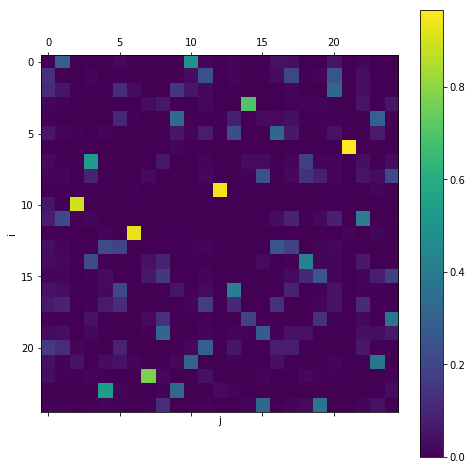

Epoch 156
Quantile : 73339.4134022, Meilleur score : 65083.7689473
Epoch 157
Quantile : 73045.7825037, Meilleur score : 63183.4166617
Epoch 158
Quantile : 73376.5934138, Meilleur score : 63261.4801732
Epoch 159
Quantile : 72591.8399898, Meilleur score : 65455.8025795
Epoch 160
Quantile : 72444.5008945, Meilleur score : 62369.6822026


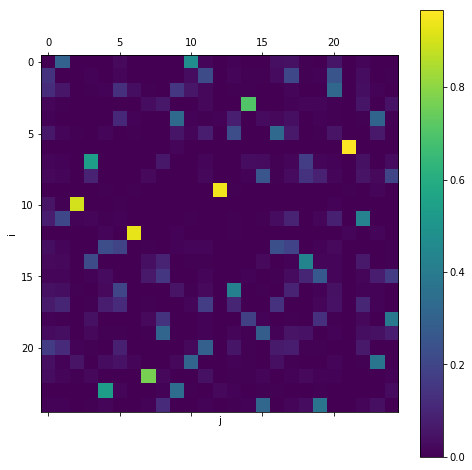

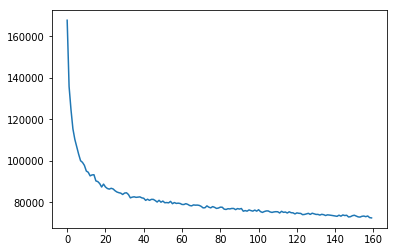

Epoch 161
Quantile : 72587.2908746, Meilleur score : 64129.8111358
Epoch 162
Quantile : 73052.7018357, Meilleur score : 66803.2942709
Epoch 163
Quantile : 73050.5379788, Meilleur score : 61276.0969842
Epoch 164
Quantile : 72696.1240613, Meilleur score : 65237.0748986
Epoch 165
Quantile : 72893.9183295, Meilleur score : 66652.6052871


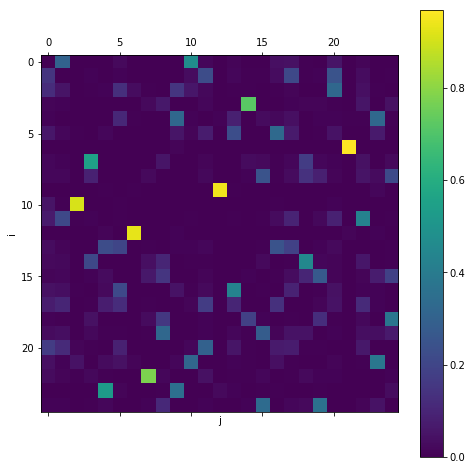

Epoch 166
Quantile : 72227.7871682, Meilleur score : 67357.1671238
Epoch 167
Quantile : 72843.2153436, Meilleur score : 64011.8552063
Epoch 168
Quantile : 72906.0168674, Meilleur score : 62369.6822026
Epoch 169
Quantile : 72529.4331614, Meilleur score : 64271.1091824
Epoch 170
Quantile : 72590.0177269, Meilleur score : 62282.5877531


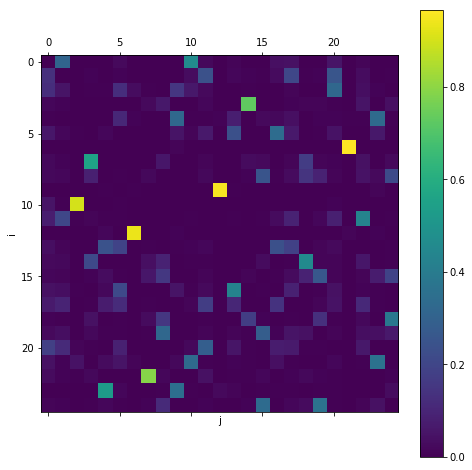

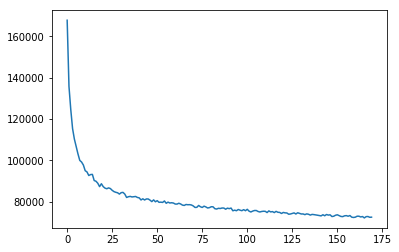

Epoch 171
Quantile : 72733.7356115, Meilleur score : 62023.3337769
Epoch 172
Quantile : 72613.8969129, Meilleur score : 65949.945892
Epoch 173
Quantile : 72634.2481893, Meilleur score : 66718.5108344
Epoch 174
Quantile : 72618.2566655, Meilleur score : 65328.8450783
Epoch 175
Quantile : 72053.4713846, Meilleur score : 63334.6665976


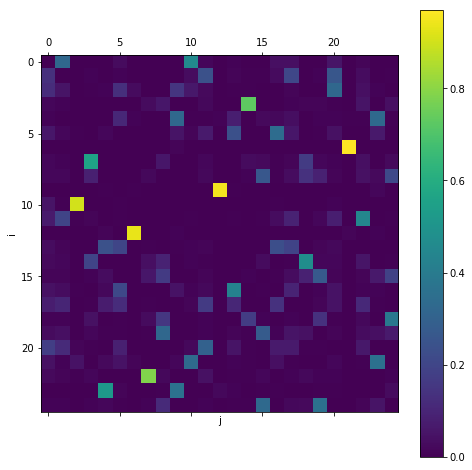

Epoch 176
Quantile : 72545.2120372, Meilleur score : 64979.9056966
Epoch 177
Quantile : 71995.5640956, Meilleur score : 64527.5369308
Epoch 178
Quantile : 72373.6597506, Meilleur score : 63334.6665976
Epoch 179
Quantile : 72553.6688243, Meilleur score : 63635.400868
Epoch 180
Quantile : 71789.3009076, Meilleur score : 63792.2629957


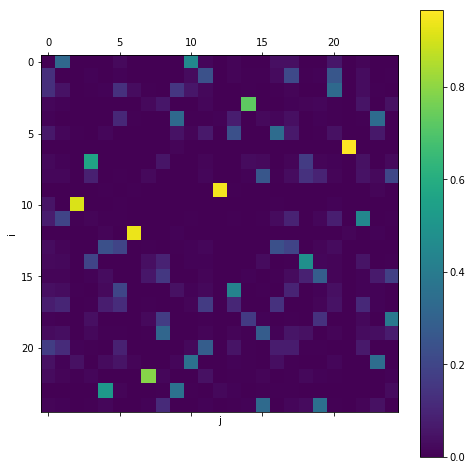

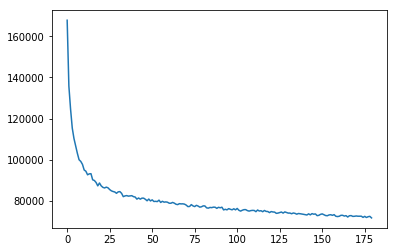

Epoch 181
Quantile : 72279.429285, Meilleur score : 65902.7330979
Epoch 182
Quantile : 72121.8664238, Meilleur score : 66118.3325651
Epoch 183
Quantile : 72156.4709139, Meilleur score : 65874.8419536
Epoch 184
Quantile : 71773.9394876, Meilleur score : 64635.2970338
Epoch 185
Quantile : 72101.6649346, Meilleur score : 62895.3782156


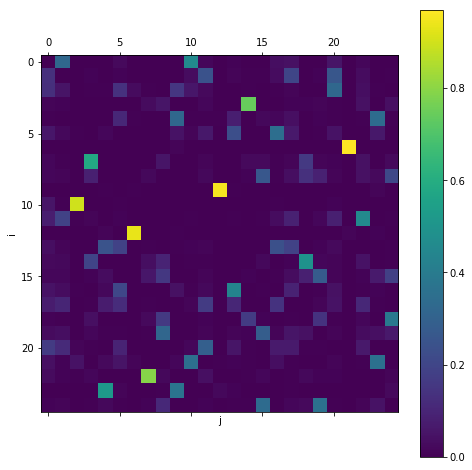

Epoch 186
Quantile : 71925.5464949, Meilleur score : 64832.9185948
Epoch 187
Quantile : 71635.7737243, Meilleur score : 62027.0472531
Epoch 188
Quantile : 72260.0692063, Meilleur score : 64536.2558562
Epoch 189
Quantile : 71614.2753642, Meilleur score : 62808.2837661
Epoch 190
Quantile : 71504.8321854, Meilleur score : 63514.3656976


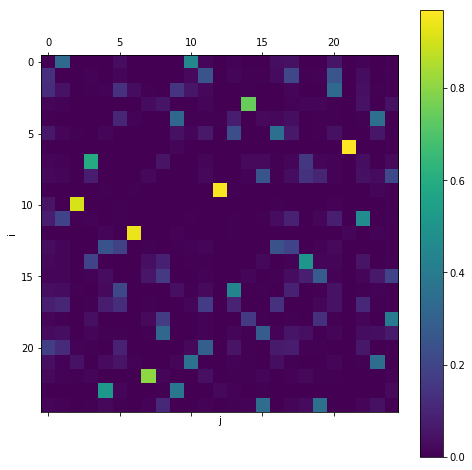

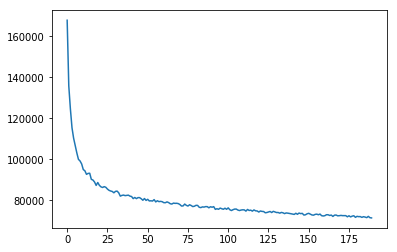

Epoch 191
Quantile : 71193.4694116, Meilleur score : 62865.3878334
Epoch 192
Quantile : 72159.7418289, Meilleur score : 66919.1392462
Epoch 193
Quantile : 71933.920256, Meilleur score : 64736.2682236
Epoch 194
Quantile : 72089.4611096, Meilleur score : 63510.0697824
Epoch 195
Quantile : 71249.4755349, Meilleur score : 64764.6909593


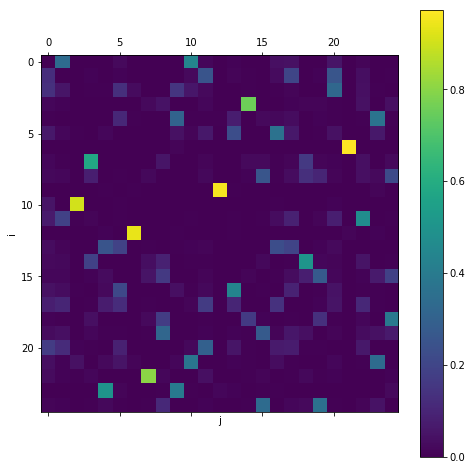

Epoch 196
Quantile : 71964.3845791, Meilleur score : 64467.8537346
Epoch 197
Quantile : 71927.4960591, Meilleur score : 63783.4627101
Epoch 198
Quantile : 71607.3820656, Meilleur score : 65840.0837543
Epoch 199
Quantile : 71807.7242532, Meilleur score : 66103.8752281
Epoch 200
Quantile : 70974.8893643, Meilleur score : 64011.8552063


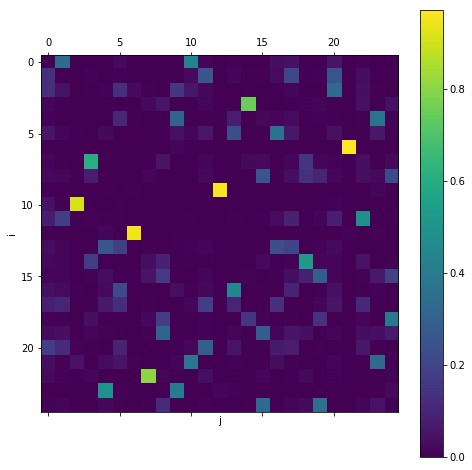

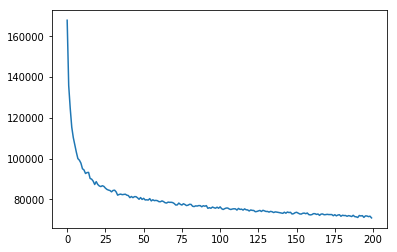

Epoch 201
Quantile : 71366.6307968, Meilleur score : 65449.8841696
Epoch 202
Quantile : 71371.9686774, Meilleur score : 65062.3126238
Epoch 203
Quantile : 71322.562847, Meilleur score : 65482.9154504
Epoch 204
Quantile : 71219.2894852, Meilleur score : 62895.3782156
Epoch 205
Quantile : 71576.1686516, Meilleur score : 63952.3830668


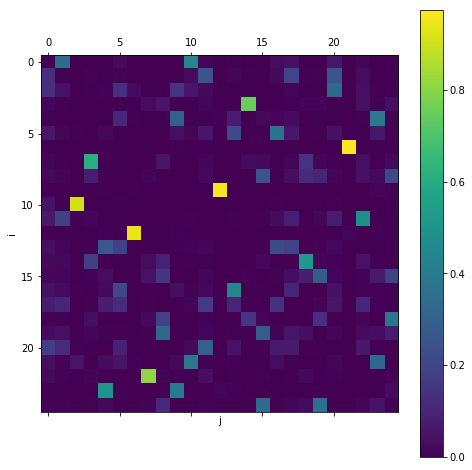

Epoch 206
Quantile : 71257.2273393, Meilleur score : 64798.0082533
Epoch 207
Quantile : 71406.308223, Meilleur score : 62369.6822026
Epoch 208
Quantile : 71898.4587269, Meilleur score : 64047.2877963
Epoch 209
Quantile : 71325.6964617, Meilleur score : 61046.8333903
Epoch 210
Quantile : 71077.6395049, Meilleur score : 63104.0478036


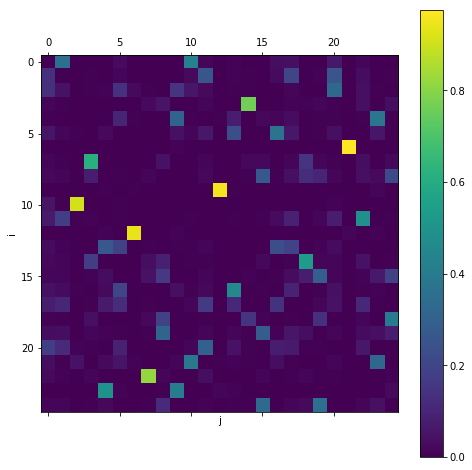

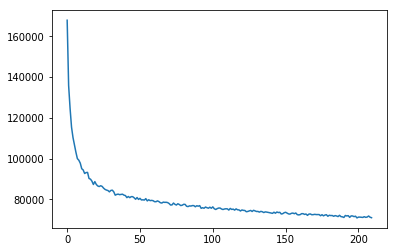

Epoch 211
Quantile : 71392.361857, Meilleur score : 67213.1381951
Epoch 212
Quantile : 70496.9191182, Meilleur score : 61315.8501278
Epoch 213
Quantile : 71151.1074098, Meilleur score : 64335.0273695
Epoch 214
Quantile : 71513.9822586, Meilleur score : 65355.1336503
Epoch 215
Quantile : 70688.9786039, Meilleur score : 62339.6918204


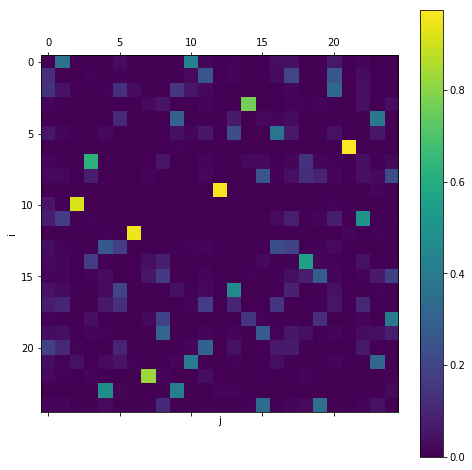

Epoch 216
Quantile : 71406.27235, Meilleur score : 62549.0297899
Epoch 217
Quantile : 70976.1674997, Meilleur score : 64129.8111358
Epoch 218
Quantile : 71017.4051449, Meilleur score : 64635.2970338
Epoch 219
Quantile : 70611.3885124, Meilleur score : 65551.9023091
Epoch 220
Quantile : 70995.9236542, Meilleur score : 63104.0478036


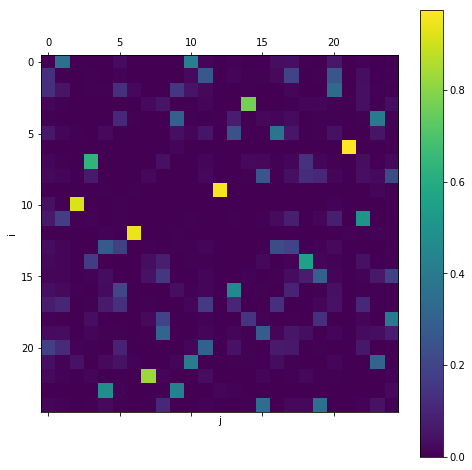

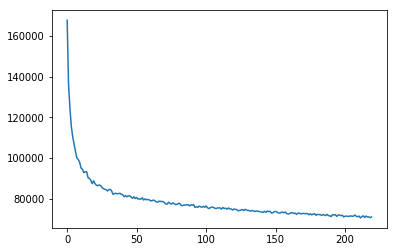

Epoch 221
Quantile : 71256.6340564, Meilleur score : 66796.8261224
Epoch 222
Quantile : 71036.1999337, Meilleur score : 62579.0201721
Epoch 223
Quantile : 71240.8173546, Meilleur score : 62579.0201721
Epoch 224
Quantile : 70769.2139505, Meilleur score : 63864.6644619
Epoch 225
Quantile : 71135.3458374, Meilleur score : 65170.5871787


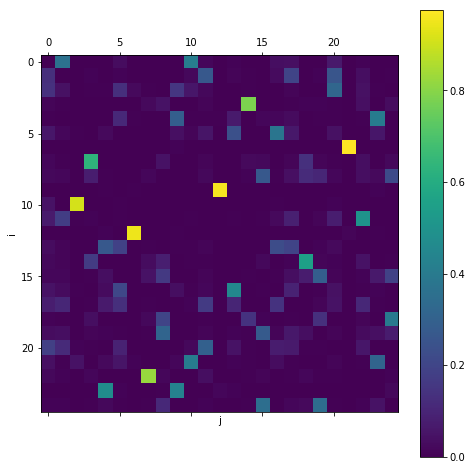

Epoch 226
Quantile : 71177.9110597, Meilleur score : 61304.5825814
Epoch 227
Quantile : 70798.2943501, Meilleur score : 64488.659676
Epoch 228
Quantile : 70259.725898, Meilleur score : 61046.8333903
Epoch 229
Quantile : 70950.6627982, Meilleur score : 62027.0472531
Epoch 230
Quantile : 70610.3699079, Meilleur score : 64099.8207536


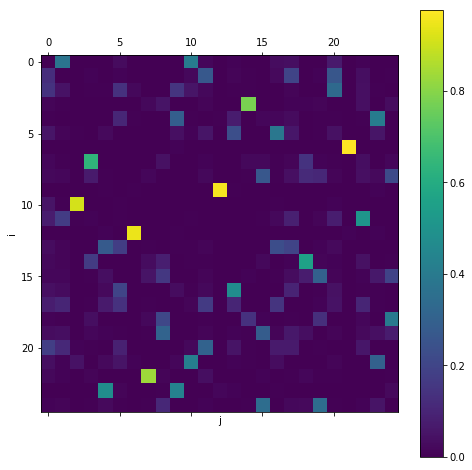

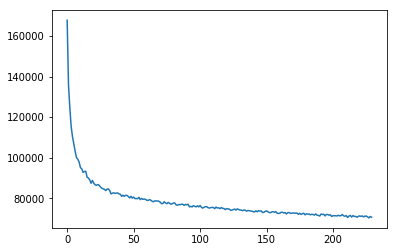

Epoch 231
Quantile : 70505.034041, Meilleur score : 63754.2375631
Epoch 232
Quantile : 70982.9179791, Meilleur score : 64387.3411119
Epoch 233
Quantile : 70174.7560024, Meilleur score : 63104.0478036
Epoch 234
Quantile : 70412.0234984, Meilleur score : 62865.3878334
Epoch 235
Quantile : 69952.5515052, Meilleur score : 63951.7589115


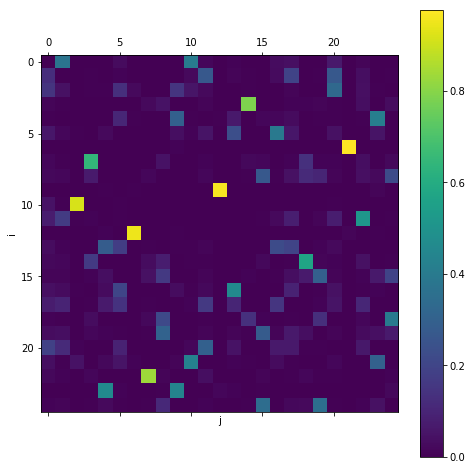

Epoch 236
Quantile : 71162.4856603, Meilleur score : 61542.5390211
Epoch 237
Quantile : 70095.5526956, Meilleur score : 62339.6918204
Epoch 238
Quantile : 70163.8573526, Meilleur score : 64387.3411119
Epoch 239
Quantile : 70113.6277972, Meilleur score : 62053.3241591
Epoch 240
Quantile : 70052.1445841, Meilleur score : 63637.1577894


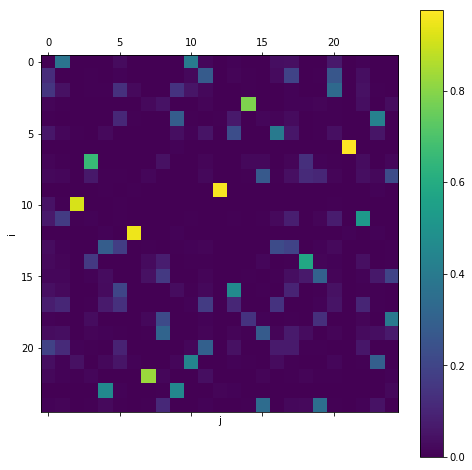

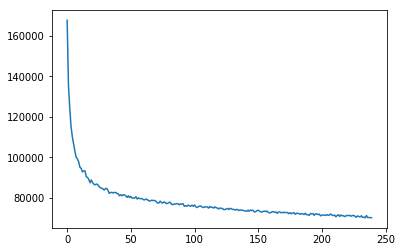

Epoch 241
Quantile : 70388.3394499, Meilleur score : 62549.0297899
Epoch 242
Quantile : 70363.5382733, Meilleur score : 63476.1085073
Epoch 243
Quantile : 70171.1665072, Meilleur score : 63361.1401321
Epoch 244
Quantile : 70035.3984109, Meilleur score : 62549.0297899
Epoch 245
Quantile : 70200.39174, Meilleur score : 62865.3878334


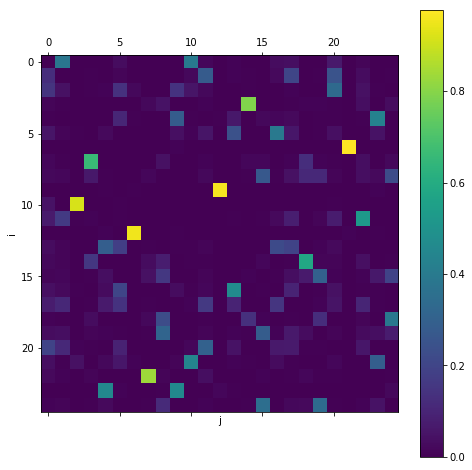

Epoch 246
Quantile : 70503.8798236, Meilleur score : 65400.1269908
Epoch 247
Quantile : 69903.1768522, Meilleur score : 61738.0936771
Epoch 248
Quantile : 69784.9093346, Meilleur score : 62023.3337769
Epoch 249
Quantile : 70326.349393, Meilleur score : 62339.6918204
Epoch 250
Quantile : 70064.0115012, Meilleur score : 64601.0358729


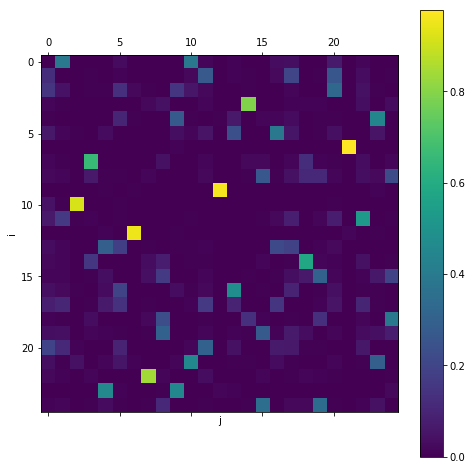

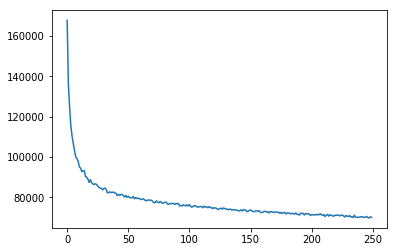

Epoch 251
Quantile : 70034.9781374, Meilleur score : 62027.0472531
Epoch 252
Quantile : 70190.2807318, Meilleur score : 61501.3512401
Epoch 253
Quantile : 69284.4908799, Meilleur score : 61572.5294033
Epoch 254
Quantile : 70136.33713, Meilleur score : 62806.9623234
Epoch 255
Quantile : 70234.4091302, Meilleur score : 62062.1244448


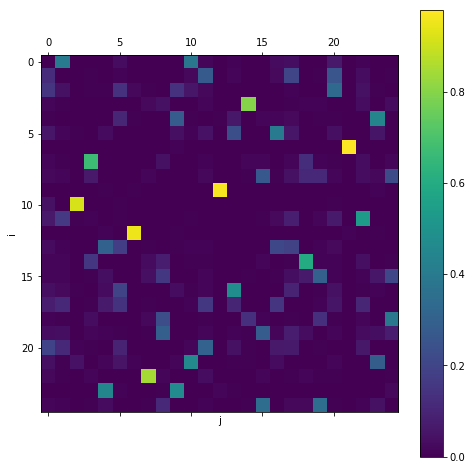

Epoch 256
Quantile : 70145.0315292, Meilleur score : 61342.520347
Epoch 257
Quantile : 69829.7944104, Meilleur score : 62549.0297899
Epoch 258
Quantile : 69866.0855346, Meilleur score : 64606.1595538
Epoch 259
Quantile : 69626.3952002, Meilleur score : 63199.2935711
Epoch 260
Quantile : 70006.6273627, Meilleur score : 63608.889841


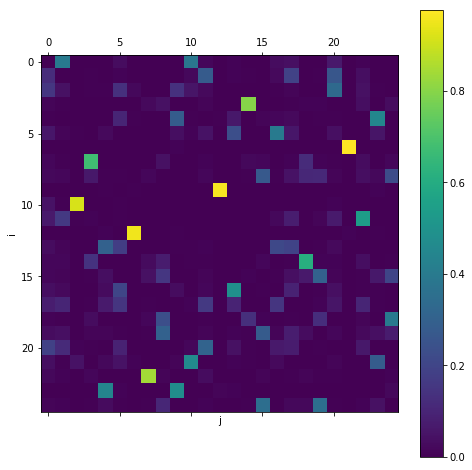

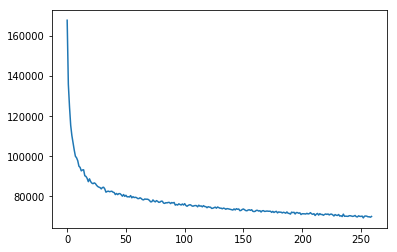

Epoch 261
Quantile : 70151.2364183, Meilleur score : 62369.6822026
Epoch 262
Quantile : 69996.9502404, Meilleur score : 61020.5564843
Epoch 263
Quantile : 69748.9881525, Meilleur score : 61379.7341726
Epoch 264
Quantile : 69781.4263305, Meilleur score : 62053.3241591
Epoch 265
Quantile : 70069.9483191, Meilleur score : 62369.6822026


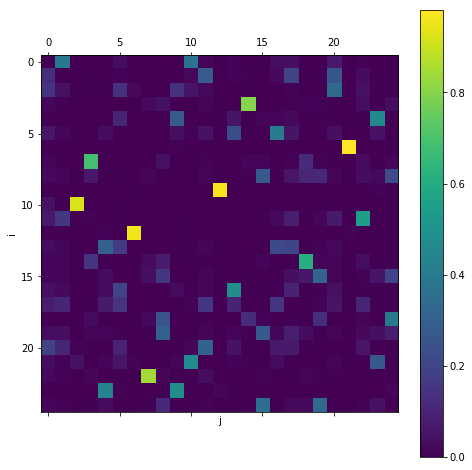

Epoch 266
Quantile : 69816.032383, Meilleur score : 62062.1244448
Epoch 267
Quantile : 69608.2424858, Meilleur score : 62062.1244448
Epoch 268
Quantile : 69504.3434354, Meilleur score : 62579.0201721
Epoch 269
Quantile : 69660.2247342, Meilleur score : 62895.3782156
Epoch 270
Quantile : 69559.2956809, Meilleur score : 62339.6918204


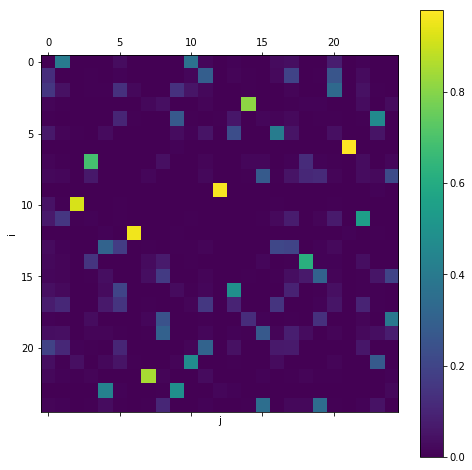

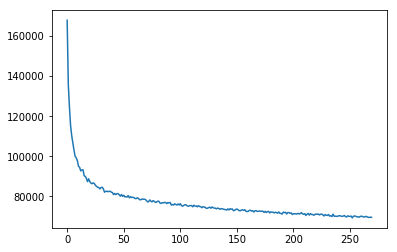

Epoch 271
Quantile : 69576.9355631, Meilleur score : 63635.400868
Epoch 272
Quantile : 69569.1441079, Meilleur score : 61276.0969842
Epoch 273
Quantile : 69536.6500757, Meilleur score : 61817.7092836
Epoch 274
Quantile : 69476.7351714, Meilleur score : 64070.9830684
Epoch 275
Quantile : 69585.4854579, Meilleur score : 61501.3512401


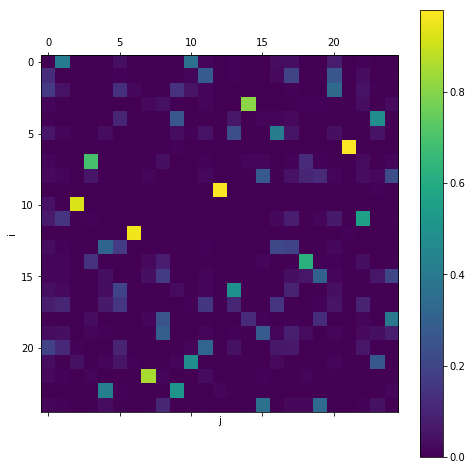

Epoch 276
Quantile : 69911.4679876, Meilleur score : 62369.6822026
Epoch 277
Quantile : 69536.902085, Meilleur score : 62053.3241591
Epoch 278
Quantile : 69722.8359413, Meilleur score : 62369.6822026
Epoch 279
Quantile : 69174.3519008, Meilleur score : 62023.3337769
Epoch 280
Quantile : 69313.3318377, Meilleur score : 62053.3241591


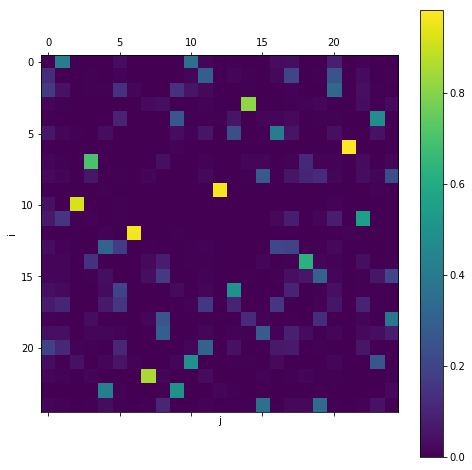

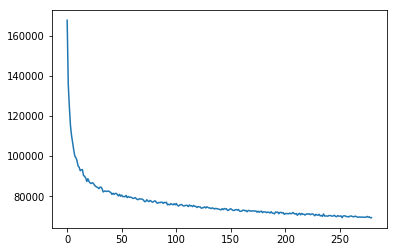

Epoch 281
Quantile : 68921.4384663, Meilleur score : 62617.6381245
Epoch 282
Quantile : 69140.5781858, Meilleur score : 62369.6822026
Epoch 283
Quantile : 69330.8444069, Meilleur score : 61501.3512401
Epoch 284
Quantile : 69439.4568877, Meilleur score : 63336.2368566
Epoch 285
Quantile : 69448.489012, Meilleur score : 62895.3782156


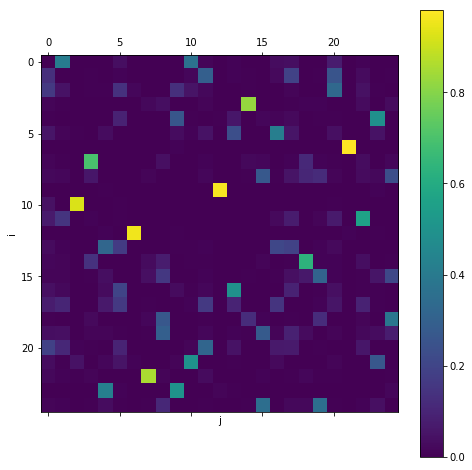

Epoch 286
Quantile : 69596.0935977, Meilleur score : 62053.3241591
Epoch 287
Quantile : 69415.8490002, Meilleur score : 62339.6918204
Epoch 288
Quantile : 68833.9148587, Meilleur score : 62369.6822026
Epoch 289
Quantile : 69551.6058972, Meilleur score : 61304.5825814
Epoch 290
Quantile : 69415.7785266, Meilleur score : 59592.8082596


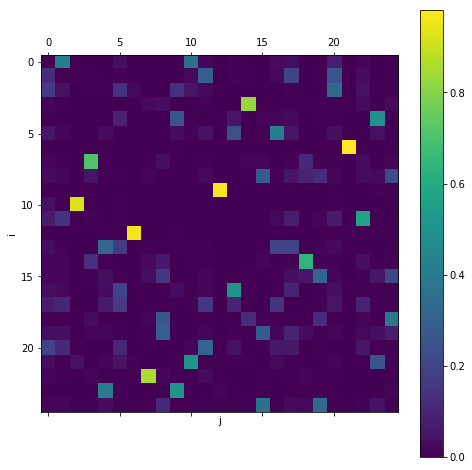

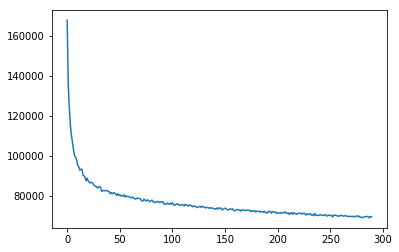

Epoch 291
Quantile : 69138.9959409, Meilleur score : 62865.3878334
Epoch 292
Quantile : 69262.1047897, Meilleur score : 64102.3077999
Epoch 293
Quantile : 68959.8829852, Meilleur score : 63806.2307129
Epoch 294
Quantile : 68743.0359804, Meilleur score : 62895.3782156
Epoch 295
Quantile : 69001.2956765, Meilleur score : 61501.3512401


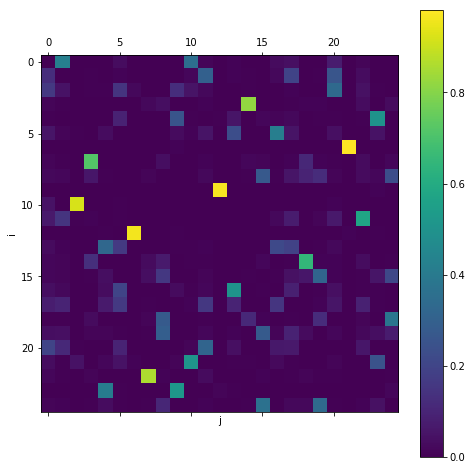

Epoch 296
Quantile : 68935.5060391, Meilleur score : 62536.8394076
Epoch 297
Quantile : 69508.4827959, Meilleur score : 64307.2476417
Epoch 298
Quantile : 69166.3784616, Meilleur score : 62865.3878334
Epoch 299
Quantile : 69269.5061543, Meilleur score : 62053.3241591
Epoch 300
Quantile : 69242.1271396, Meilleur score : 63113.1842102


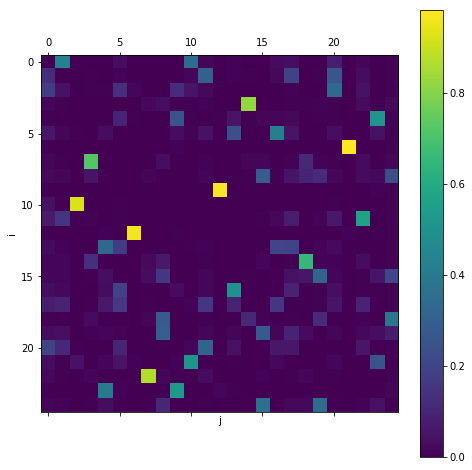

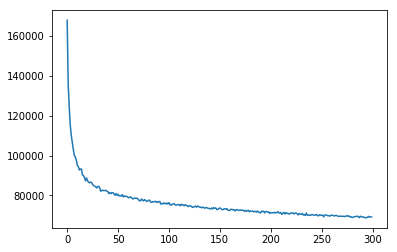

Epoch 301
Quantile : 68846.9357016, Meilleur score : 64123.2633054
Epoch 302
Quantile : 69145.4341954, Meilleur score : 62617.6381245
Epoch 303
Quantile : 69159.3592268, Meilleur score : 62826.976094
Epoch 304
Quantile : 68453.8170402, Meilleur score : 62369.6822026
Epoch 305
Quantile : 68586.7391563, Meilleur score : 62053.3241591


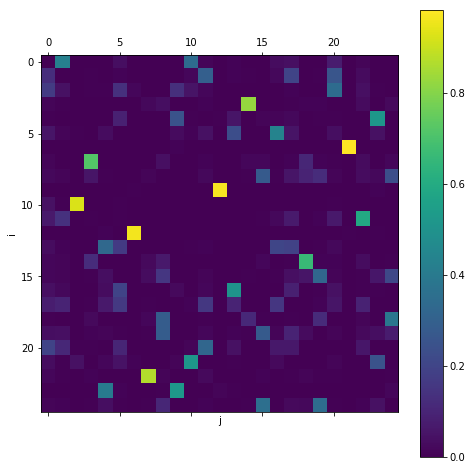

Epoch 306
Quantile : 68723.5599298, Meilleur score : 62369.6822026
Epoch 307
Quantile : 68606.7511343, Meilleur score : 62023.3337769
Epoch 308
Quantile : 68955.9034659, Meilleur score : 62343.4052966
Epoch 309
Quantile : 68696.7433777, Meilleur score : 61501.3512401
Epoch 310
Quantile : 68398.9158382, Meilleur score : 62369.6822026


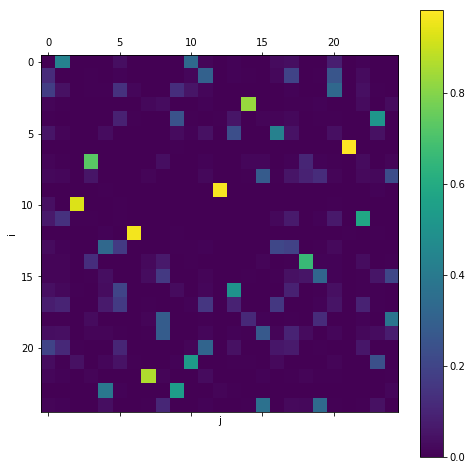

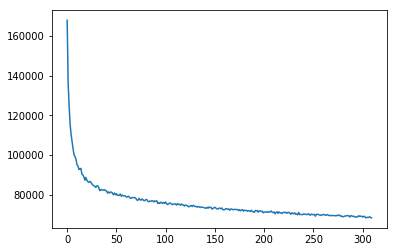

Epoch 311
Quantile : 68919.8120427, Meilleur score : 62975.1893287
Epoch 312
Quantile : 69017.5017081, Meilleur score : 62528.0391219
Epoch 313
Quantile : 68598.532138, Meilleur score : 61801.7929972
Epoch 314
Quantile : 69017.2015118, Meilleur score : 61830.2785944
Epoch 315
Quantile : 68787.9066245, Meilleur score : 62339.6918204


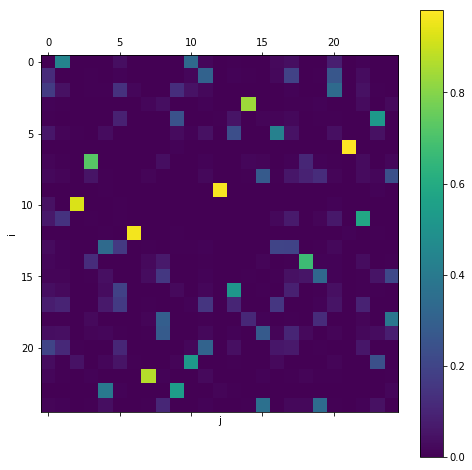

Epoch 316
Quantile : 68460.5055714, Meilleur score : 61025.6432937
Epoch 317
Quantile : 69190.3264481, Meilleur score : 63367.2348311
Epoch 318
Quantile : 68769.6927845, Meilleur score : 63683.5928746
Epoch 319
Quantile : 68614.9509453, Meilleur score : 62369.6822026
Epoch 320
Quantile : 69026.5076351, Meilleur score : 62027.0472531


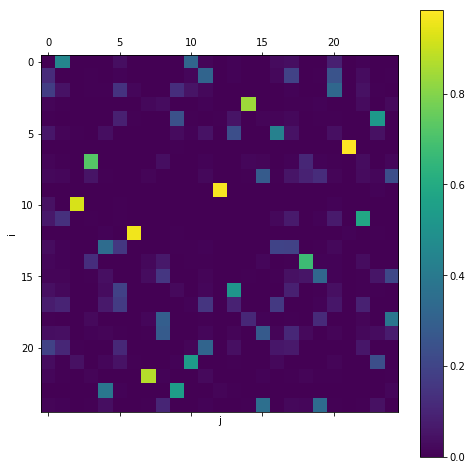

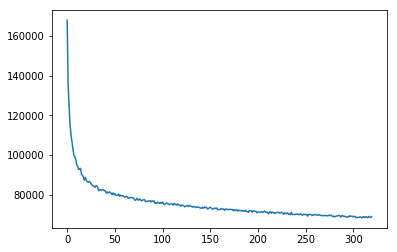

Epoch 321
Quantile : 68990.7399706, Meilleur score : 62053.3241591
Epoch 322
Quantile : 68549.2682075, Meilleur score : 62329.7460878
Epoch 323
Quantile : 67640.9402701, Meilleur score : 62053.3241591
Epoch 324
Quantile : 68785.8432096, Meilleur score : 59592.8082596
Epoch 325
Quantile : 68507.9340403, Meilleur score : 61046.8333903


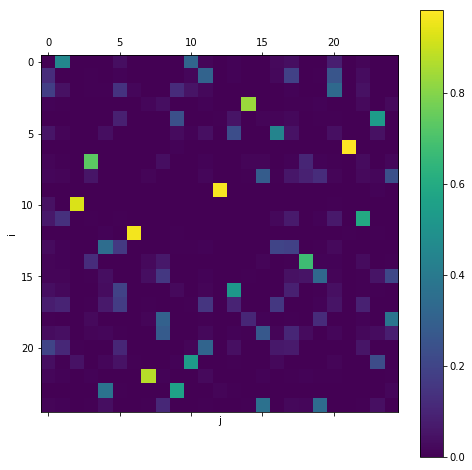

Epoch 326
Quantile : 68537.0998021, Meilleur score : 61501.3512401
Epoch 327
Quantile : 68398.8554123, Meilleur score : 62023.3337769
Epoch 328
Quantile : 68127.891886, Meilleur score : 62579.0201721
Epoch 329
Quantile : 67859.7729595, Meilleur score : 61387.5136875
Epoch 330
Quantile : 68779.9971478, Meilleur score : 60073.6030154


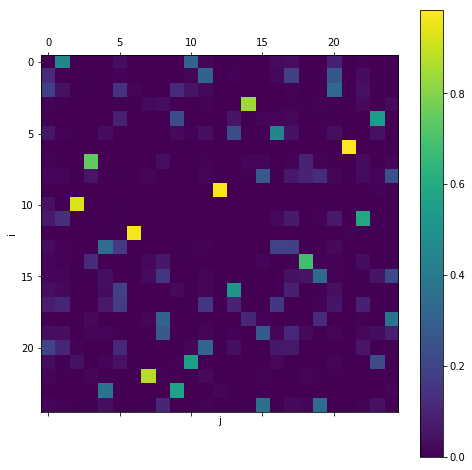

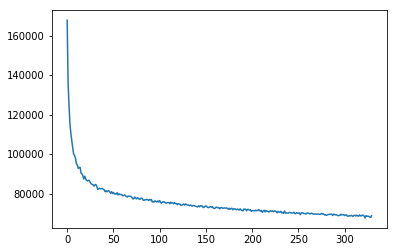

Epoch 331
Quantile : 68025.5218432, Meilleur score : 61830.2785944
Epoch 332
Quantile : 68182.9561423, Meilleur score : 62053.3241591
Epoch 333
Quantile : 68373.0178863, Meilleur score : 62097.5570348
Epoch 334
Quantile : 68587.9272668, Meilleur score : 60599.2990285
Epoch 335
Quantile : 67747.6537142, Meilleur score : 61387.5136875


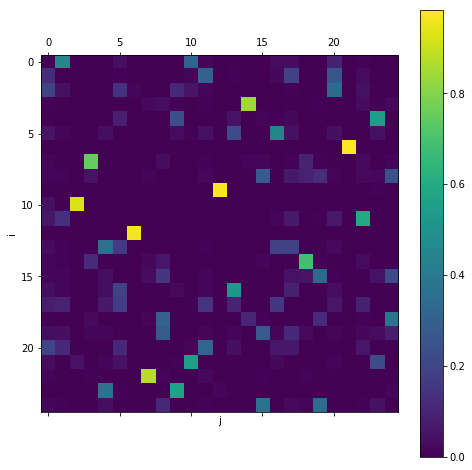

Epoch 336
Quantile : 68091.2908427, Meilleur score : 62369.6822026
Epoch 337
Quantile : 68060.2483698, Meilleur score : 61572.5294033
Epoch 338
Quantile : 68297.7182035, Meilleur score : 62023.3337769
Epoch 339
Quantile : 67916.5961307, Meilleur score : 62343.4052966
Epoch 340
Quantile : 68281.4523056, Meilleur score : 62053.3241591


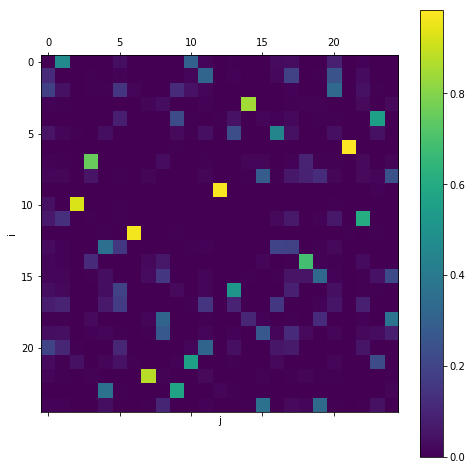

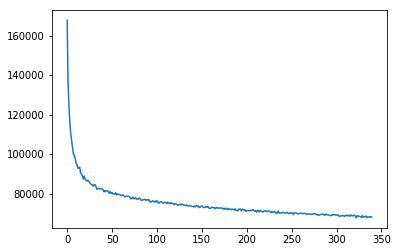

Epoch 341
Quantile : 68256.6769276, Meilleur score : 59067.1122466
Epoch 342
Quantile : 68075.1094587, Meilleur score : 61294.7893122
Epoch 343
Quantile : 67993.1539578, Meilleur score : 62369.6822026
Epoch 344
Quantile : 67755.0326592, Meilleur score : 60599.2990285
Epoch 345
Quantile : 67650.5288441, Meilleur score : 62053.3241591


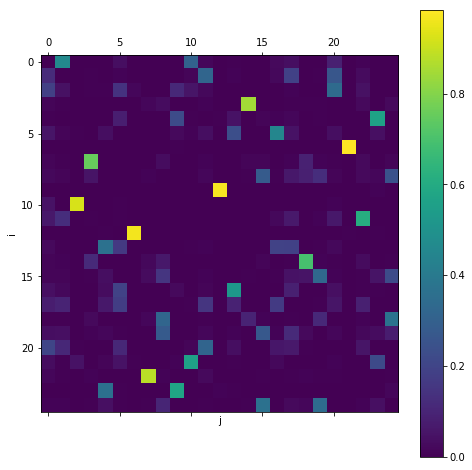

Epoch 346
Quantile : 68087.1644804, Meilleur score : 61817.7092836
Epoch 347
Quantile : 68254.0279778, Meilleur score : 61501.3512401
Epoch 348
Quantile : 68338.5641655, Meilleur score : 60073.6030154
Epoch 349
Quantile : 67653.1472151, Meilleur score : 60073.6030154
Epoch 350
Quantile : 67998.9780014, Meilleur score : 62369.6822026


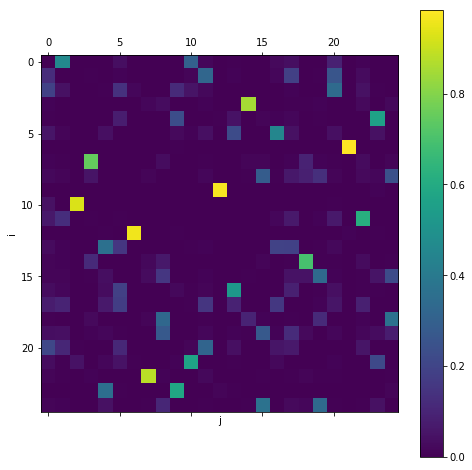

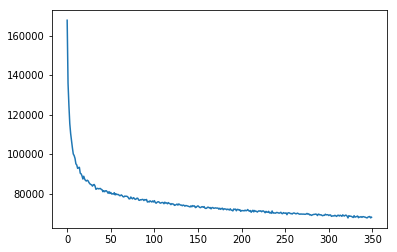

Epoch 351
Quantile : 68308.6298078, Meilleur score : 62528.0391219
Epoch 352
Quantile : 67884.7331625, Meilleur score : 62023.3337769
Epoch 353
Quantile : 68045.6107744, Meilleur score : 62282.5877531
Epoch 354
Quantile : 67873.680277, Meilleur score : 61156.6886078
Epoch 355
Quantile : 67462.6213006, Meilleur score : 61304.5825814


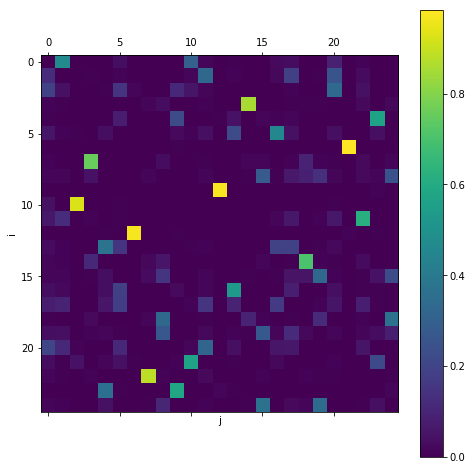

Epoch 356
Quantile : 68072.8202041, Meilleur score : 62023.3337769
Epoch 357
Quantile : 67724.2222249, Meilleur score : 61620.9406249
Epoch 358
Quantile : 67811.8339706, Meilleur score : 60073.6030154
Epoch 359
Quantile : 67646.2024609, Meilleur score : 62343.4052966
Epoch 360
Quantile : 67525.0032516, Meilleur score : 62369.6822026


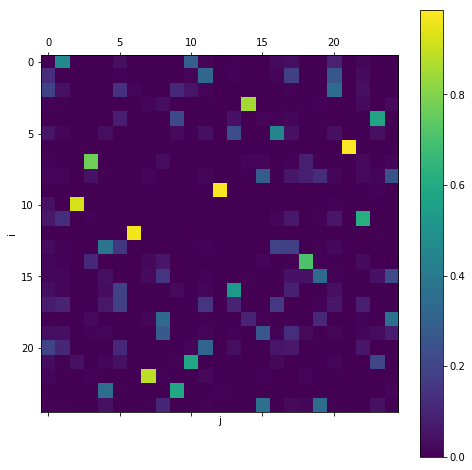

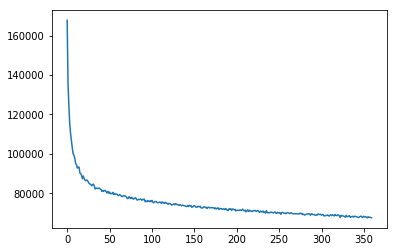

Epoch 361
Quantile : 67907.6144103, Meilleur score : 61501.3512401
Epoch 362
Quantile : 67784.5615312, Meilleur score : 61801.7929972
Epoch 363
Quantile : 68358.883795, Meilleur score : 61817.7092836
Epoch 364
Quantile : 67758.1730458, Meilleur score : 61501.3512401
Epoch 365
Quantile : 67813.3657524, Meilleur score : 61046.8333903


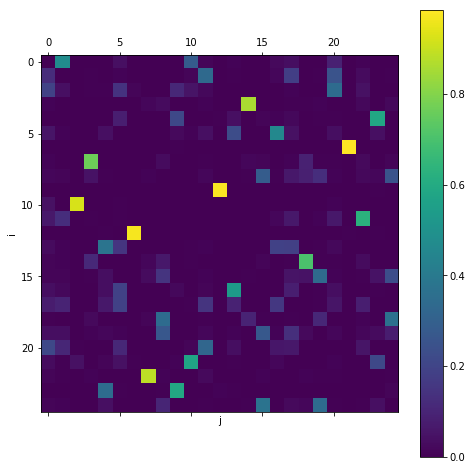

Epoch 366
Quantile : 68289.3585369, Meilleur score : 62240.1766691
Epoch 367
Quantile : 67500.4976595, Meilleur score : 61501.3512401
Epoch 368
Quantile : 67455.9134306, Meilleur score : 61304.5825814
Epoch 369
Quantile : 67627.9932452, Meilleur score : 62053.3241591
Epoch 370
Quantile : 67537.4958989, Meilleur score : 62301.280081


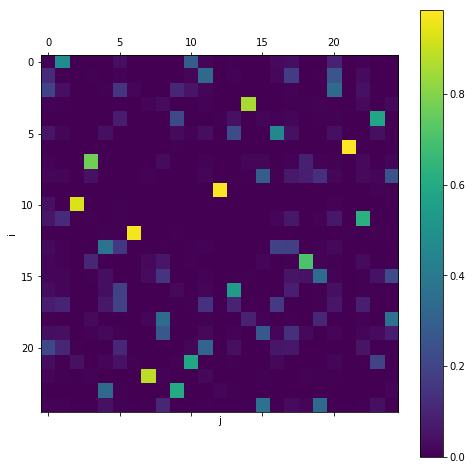

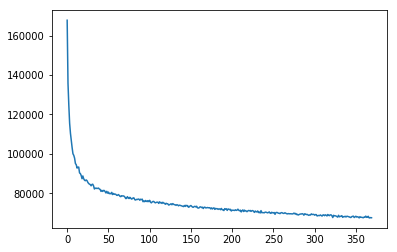

Epoch 371


KeyboardInterrupt: 

In [56]:
%%time
tsp_Bayes = CE_solution(c,method="Bayes", perc = 1)

In [109]:
#print(tsp_Bayes.solution)

### Affichage sur une carte

In [111]:
import folium

In [146]:
def plot_my_world_tour(permut1,df,tsp2=None, line=True):
    
    locations1 = df.iloc[permut1,:][['lat', 'lng']]
    names1 = df.iloc[permut1,:]['city_ascii']
    locationlist1 = locations1.values.tolist()

    #centre la map sur Paris
    map_osm = folium.Map(location=[48.82, 2.26],zoom_start=1.5)

    #affiche les villesp points pas points
    for point in range(0, len(locationlist1)):
        folium.Marker(locationlist1[point], popup=names1.iloc[point]).add_to(map_osm)
        
    #relie les villes entre elles selon le tour optimal
    if line:
        folium.PolyLine(locationlist1).add_to(map_osm)
    
    if tsp2:

        permut2 = tsp2.solution
        locations2 = df.iloc[permut2,:][['lat', 'lng']]
        names2 = df.iloc[permut2,:]['city_ascii']
        locationlist2 = locations2.values.tolist()
        
        #affiche les villesp points pas points
        for point in range(0, len(locationlist2)):
            folium.Marker(locationlist2[point], popup=names2.iloc[point]).add_to(map_osm)

        #relie les villes entre elles selon le tour optimal
        folium.PolyLine(locationlist2, color="red").add_to(map_osm)

    map_osm.save("map3.html")

    return map_osm
    

In [116]:
plot_my_world_tour(tsp_Smooth.solution,df,line=True)

In [123]:
l = [0, 10, 34, 37, 31, 46,21, 6, 8, 30, 18, 4, 2, 14, 20, 5, 45, 25, 35, 27, 13, 9, 11, 12, 24, 26, 36, 15, 47, 22, 32, 23, 44, 16, 40, 49, 33, 43, 39, 28, 1, 42, 7, 19, 3, 17, 41, 38, 29, 48, 0]

In [144]:
ll = [0, 20,  1, 11, 22,  7,  3, 14, 18,  8, 24, 15, 19, 17, 16, 13,  5,  4, 23,  9, 12,  6, 21,  2, 10 , 0]

In [145]:
plot_my_world_tour(ll,df,line=False)

In [147]:
plot_my_world_tour(ll,df)

# Autres examples

## GR17

GR17 is a set of 17 cities, from TSPLIB. The minimal tour has length 2085.

Meilleur score obtenu par l'algo : 2096

In [4]:
c = np.loadtxt('https://people.sc.fsu.edu/~jburkardt/datasets/tsp/gr17_d.txt')

In [5]:
c.shape

(17, 17)

In [28]:
%%time
#TSP = CE_solution(c,k=5,perc=1)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs


## ATT48

ATT48 is a set of 48 cities (US state capitals) from TSPLIB. The minimal tour has length 10628.

Meilleur score obtenu par l'algo : 

Sur ce dataset on est tres loin de la solution optimale !!!!!! (pourquoi? )

In [8]:
c = np.loadtxt('https://people.sc.fsu.edu/~jburkardt/datasets/tsp/att48_d.txt')
c.shape

(48, 48)

In [29]:
%%time
#TSP = CE_solution(c,k=5,perc=1)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 7.15 µs


## ft53

Dataset de l'article

In [ ]:
def read_atsp(url):
     
    ds = np.DataSource()
    input_f = ds.open(url)
    num_lines_skip = 6
    lst = []
     
    for i, line in enumerate(input_f):
    
        if (i <= num_lines_skip) or ('EOF' in line):
            continue

        else:
            lst.append(line)
  
    lst = ''.join(lst).replace('\n', '').split()
     
    return np.array(lst, dtype=int).reshape(53, 53)

In [ ]:
c = read_atsp('http://elib.zib.de/pub/mp-testdata/tsp/tsplib/atsp/ft53.atsp')

In [ ]:
c.shape

In [ ]:
for i in range(c.shape[0]):
    c[i,i] = 0

In [ ]:
c

In [ ]:
def CE_solution(c,k=10,alpha=0.7,perc=1,stop=5):
    TSP = TSPCrossEntropy(c,k=k,alpha=alpha,perc=perc,stop=stop)
    TSP.CE_fit()
    return TSP

In [ ]:
%%time
#TSP = CE_solution(c)